# Main unsolved issues about IMPACT

Created: **17/07/18**  
Last modified: **01/08/18**

**Goal:** list of all the unsolved questions/issues found in the raw data `all_IMPACT_mutations_180508.txt`, this notebook should be read in the context of `first_analysis.ipynb` which periodically refers to it.  
This notebook is divided in four parts, each part corresponding to an unsolved question:
* **1. Some `n_depth` read = 0**
* **2. Some `n_vaf` are really high**
* **3. One sample has 2983 mutations, mostly `synonymous_SNV`**
* **4. The `Consequence` feature is sometimes inconsistent with `Variant_Type` and `HGVSp_Short`**

**Refs:**
* `first_analysis.ipynb`
* `custom_tools.R`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Some-n_depth-read-=-0" data-toc-modified-id="Some-n_depth-read-=-0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some <code>n_depth</code> read = 0</a></span></li><li><span><a href="#Some-n_vaf-are-really-high" data-toc-modified-id="Some-n_vaf-are-really-high-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Some <code>n_vaf</code> are really high</a></span></li><li><span><a href="#One-sample-has-2983-mutations,-mostly-synonymous_SNV" data-toc-modified-id="One-sample-has-2983-mutations,-mostly-synonymous_SNV-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>One sample has 2983 mutations, mostly <code>synonymous_SNV</code></a></span></li><li><span><a href="#The-Consequence-feature-is-sometimes-inconsistent-with-Variant_Type-and-HGVSp_Short" data-toc-modified-id="The-Consequence-feature-is-sometimes-inconsistent-with-Variant_Type-and-HGVSp_Short-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The <code>Consequence</code> feature is sometimes inconsistent with <code>Variant_Type</code> and <code>HGVSp_Short</code></a></span><ul class="toc-item"><li><span><a href="#Variant_Type" data-toc-modified-id="Variant_Type-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>Variant_Type</code></a></span></li><li><span><a href="#HGVSp_Short" data-toc-modified-id="HGVSp_Short-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>HGVSp_Short</code></a></span></li></ul></li><li><span><a href="#Bla" data-toc-modified-id="Bla-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bla</a></span><ul class="toc-item"><li><span><a href="#Consequence" data-toc-modified-id="Consequence-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span><code>Consequence</code></a></span></li><li><span><a href="#HGVSp_Short" data-toc-modified-id="HGVSp_Short-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span><code>HGVSp_Short</code></a></span></li></ul></li></ul></div>

***

In [1]:
source("../../../src/utils/custom_tools.R")
setup_environment()

In [2]:
# old version [24/07/18]
get_cleaned_impact <- function(data_folder_name) {

  # [+35 features, +588,547 rows] get the original dataset
  impact <- read.table(paste0(data_folder_name, "/all_IMPACT_mutations_180508.txt"), sep = "\t", stringsAsFactors = FALSE, header = TRUE)


  # [-7 features] remove the unique-value features
  impact[, c("Entrez_Gene_Id",
             "Center",
             "NCBI_Build",
             "Strand",
             "dbSNP_RS",
             "Matched_Norm_Sample_Barcode",
             "variant_status")] <- NULL


  # [-3 features] remove the redundant features
  impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- NULL


  # [-322,796 rows] remove the non-interesting mutations
  impact <- impact[impact$Consequence %in% c("stopgain_SNV",
                                             "splicing",
                                             "nonsynonymous_SNV",
                                             "nonframeshift_insertion",
                                             "nonframeshift_deletion",
                                             "frameshift_insertion",
                                             "frameshift_deletion",
                                             "synonymous_SNV"),]


  # [-12,975 rows] remove the contaminated rows
  impact <- impact[impact$minor_contamination <= 0.01,]
  # [-1 feature] remove the minor_contamination feature
  impact["minor_contamination"] <- NULL


  # [-46 rows] remove the rows having impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count
  impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]


  # [+1 feature] create a mutation key feature to idenfity unique mutations
  impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')


  # [modify 7501 rows] replace the wrong Hugo symbols with the good ones
  old_Hugo_Symbol = c('MLL3', 'PAK7', 'RFWD2', 'MYCL1', 'MLL2', 'MLL', 'FAM46C', 'MRE11A', 'PARK2', 'FAM175A',
                      'TCEB1', 'WHSC1', 'WHSC1L1', 'FAM58A', 'SETD8', 'MLL4')
  new_Hugo_Symbol = c('KMT2C', 'PAK5', 'COP1', 'MYCL', 'KMT2D', 'KMT2A', 'TENT5C', 'MRE11', 'PRKN', 'ABRAXAS1',
                      'ELOC', 'NSD2', 'NSD3', 'CCNQ', 'KMT5A', 'KMT2B')
  old_symbols <- which(impact$Hugo_Symbol %in% old_Hugo_Symbol)
  impact$Hugo_Symbol[old_symbols] <- new_Hugo_Symbol[match(impact$Hugo_Symbol[old_symbols], old_Hugo_Symbol)]

  # [modify 1334 rows] replace "CDKN2Ap16INK4A" by "CDKN2A"
  impact$Hugo_Symbol[impact$Hugo_Symbol == "CDKN2Ap16INK4A"] <- "CDKN2A"
  # [-808 rows] delete the "CDKN2Ap14ARF" already read in the classic read frame (in "CDKN2Ap16INK4A")
  impact <- impact %>% filter(! (Hugo_Symbol == "CDKN2Ap14ARF" & mut_key %in% impact$mut_key[impact$Hugo_Symbol == "CDKN2A"]))


  # [-57 rows] remove the duplicated mutations
  impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')
  impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
  impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth))
  impact_redundant_to_delete <- impact_redundant_to_delete %>% group_by(sample_mut_key) %>% filter(t_vaf == min(t_vaf))
  impact <- impact %>% filter(! (sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                                 t_depth %in% impact_redundant_to_delete$t_depth &
                                 t_vaf %in% impact_redundant_to_delete$t_vaf))
  impact$sample_mut_key <- NULL


  #  [modify every rows] replace the occurence_in_normals feature by frequency_in_normals
  impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
  impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                        function(s) as.double(strsplit(s, split = ';')[[1]][2]))
  impact$occurence_in_normals <- NULL


  # [modify 24 rows] set all the `synonymous_SNV` as "UNKNOWN" for consistancy (24 were classified as "UNLIKELY")
  impact$confidence_class[impact$Consequence == "synonymous_SNV"] <- "UNKNOWN"


  return (impact)
}

In [3]:
impact <- get_cleaned_impact("../../../data") # an old version before the problems were solved [24/07/18] - see hiden cell above

## Some `n_depth` read = 0

<font color='red'> **Decision:** The decision has been made to filter every mutations having a `n_depth < 20`, these mutations are thus not part of the cleaned dataset anymore. </font>

In [4]:
summary(impact$n_depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   361.0   497.0   525.9   660.0  5958.0 

There is something weird with some data having 0 or really a few `n_depth` reads. How did they identify the somatic mutations from these parts of the genes? Did they refer to a reference genome? Apparently the `confidence_class` attribute doesn't depend on this value.  

In [5]:
addmargins(table(impact[impact$n_depth == 0,]$confidence_class))  # 27  rows with n_depth == 0
addmargins(table(impact[impact$n_depth <= 10,]$confidence_class)) # 175 rows with n_depth <= 10


  AUTO_OK MANUAL_OK OK_NOT_SO   UNKNOWN  UNLIKELY       Sum 
        5         3         1         5        13        27 


  AUTO_OK MANUAL_OK OK_NOT_SO   UNKNOWN  UNLIKELY       Sum 
       37        17         1        26        94       175 

No correlation found with gene, `confidence_class`, `Variant_Type` or `Consequence`:

[1] "Number of different genes:  22"


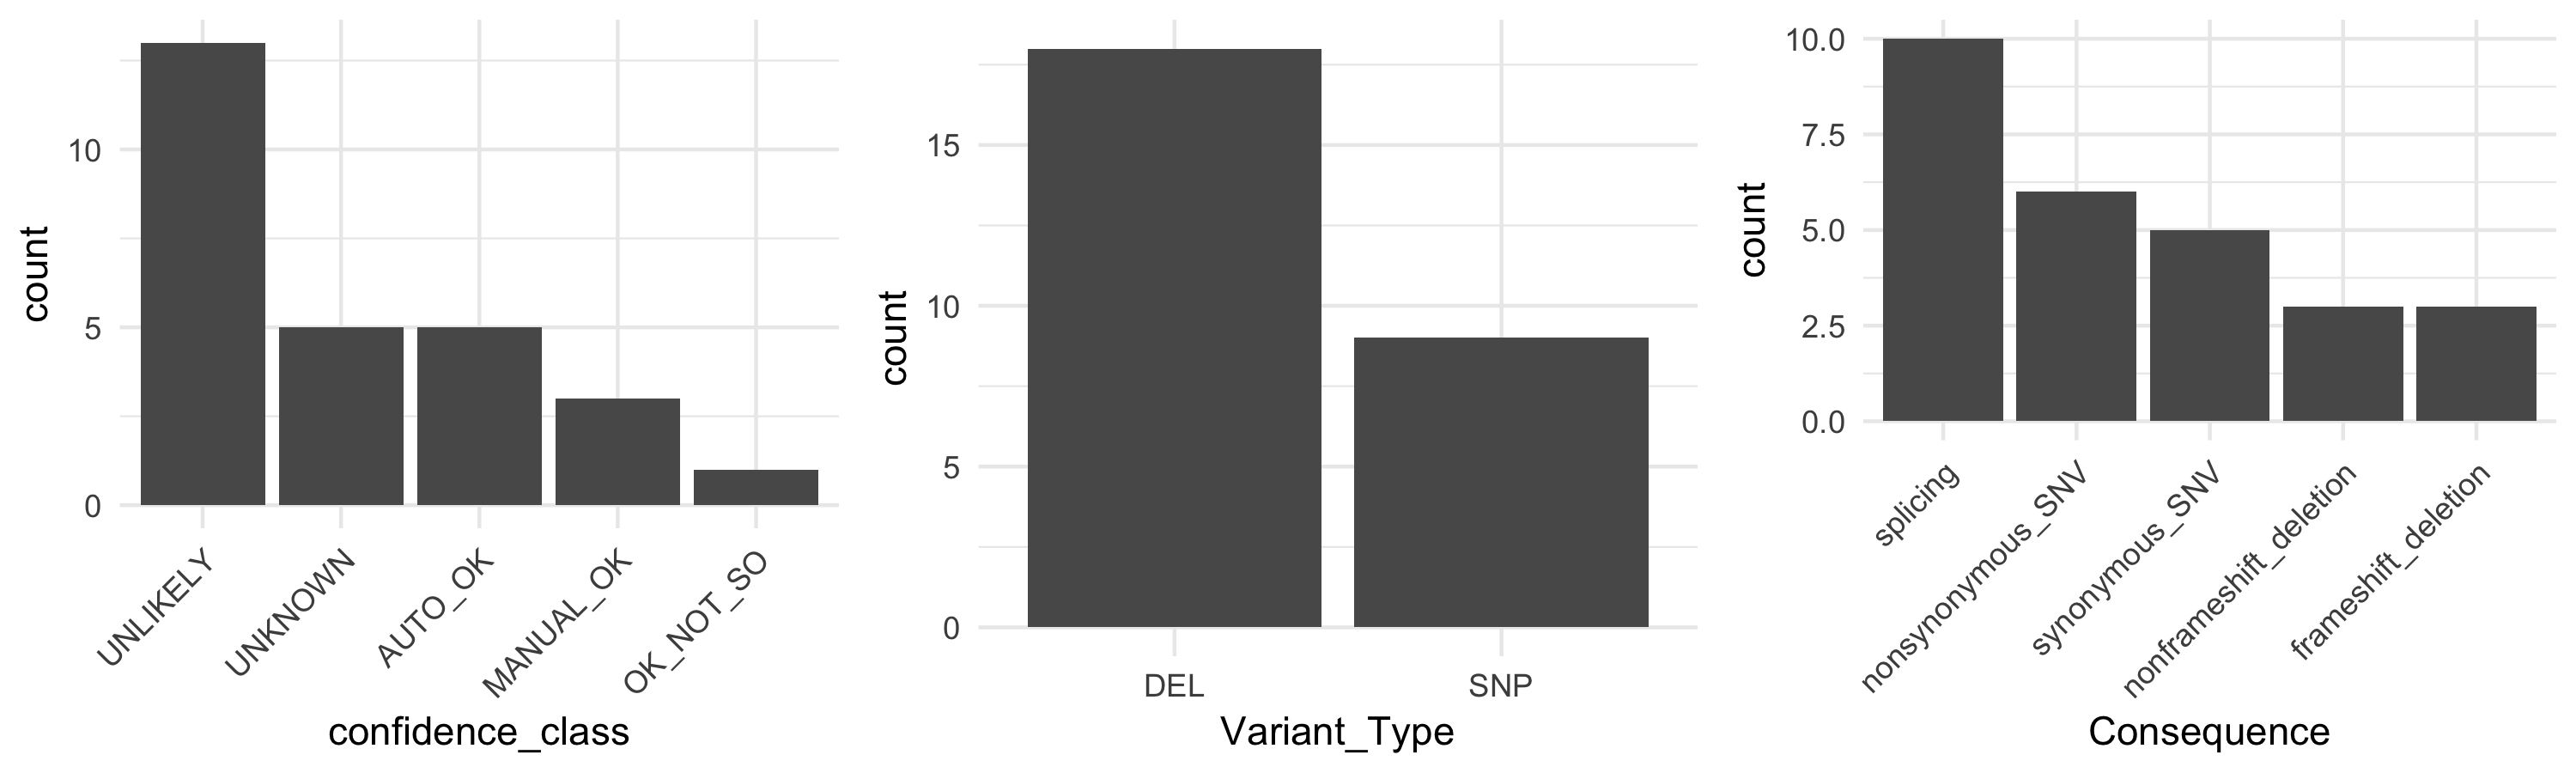

In [6]:
get_possible_correlations(impact[impact$n_depth == 0,])

[1] "Number of different genes:  69"


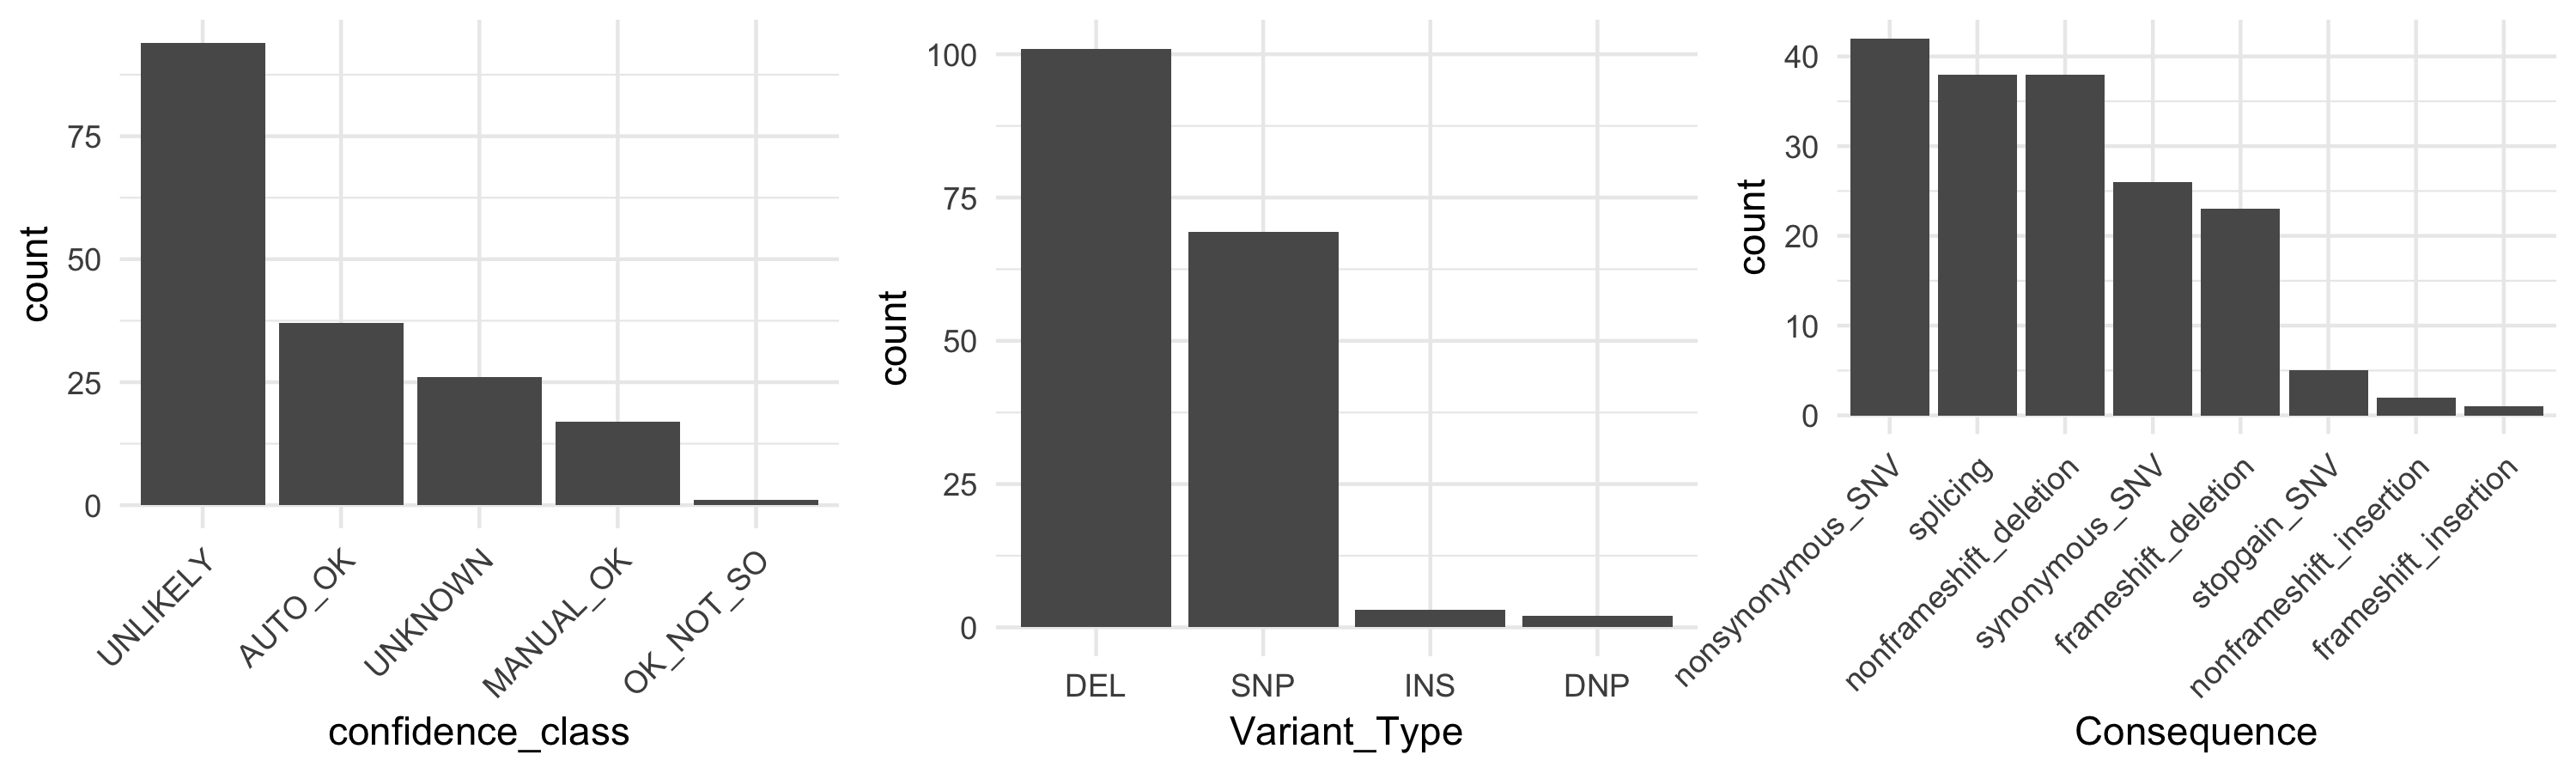

In [7]:
get_possible_correlations(impact[impact$n_depth <= 10,])

**Possible answer**

[MSK-IMPACT 2015 article](https://www.sciencedirect.com/science/article/pii/S1525157815000458?via%3Dihub)
* **Material and Methods/SNVs and Indels in Variant Calling, p.254-255)**
    * "[...] where a matched normal sample was unavailable, or where the matched normal sample was sequenced with low coverage ($<50\times$), tumor samples were considered as unmatched samples, and variant calling was performed using a within-batch mixed normal control sample instead."
    * "In cases where variant calling was performed using an unmatched normal sample, variants with minor allele frequency $>1\%$ in the 1000 Genomes cohort were also removed because they were more likely to be common population polymorphisms than somatic mutations."
* **Results/Optimization of Mutation Calling Filters, p.257**: "In cases were a patient-matched normal sample is unavailable, or is sequenced with low coverage ($<50\%$), variant calling is performed against an unmatched, pooled normal control instead."
* **Results/Clinical Validation in Samples with Known SNVs and Indels, p.259**: "Variant calling in tumors with patient-matched normal generated 6 somatic calls on average, compared to 15 calls on average for tumors where no matched normal was available."

This doesn't provide an answer as the low or $=0$ `n_depth` values of these cases are not shared by every mutations for one tumor sample:

In [8]:
# n_depth being 0 is not unique per Tumor_Sample_Barcode
dd <- impact %>% group_by(Tumor_Sample_Barcode) %>%
                summarise(count = length(unique(n_depth)), n_depth_values = toString(unique(n_depth)))
head(dd[grep(' 0,', dd$n_depth_values),])

Tumor_Sample_Barcode,count,n_depth_values
P-0003195-T02-IM6,9,"513, 696, 734, 554, 543, 318, 0, 512, 368"
P-0003540-T01-IM5,6,"370, 470, 266, 189, 0, 274"
P-0006077-T01-IM5,7,"590, 502, 422, 576, 0, 371, 167"
P-0007040-T01-IM5,7,"439, 569, 979, 0, 575, 513, 487"
P-0008378-T01-IM5,26,"229, 418, 325, 491, 608, 380, 34, 390, 306, 399, 333, 483, 305, 769, 242, 398, 331, 93, 439, 459, 247, 69, 573, 0, 54, 65"
P-0010610-T01-IM5,21,"374, 279, 400, 227, 259, 435, 614, 345, 559, 289, 265, 339, 513, 0, 580, 490, 920, 337, 347, 367, 553"


## Some `n_vaf` are really high

<font color='red'> **Decision:** The decision has been made to keep all these mutations, as they represent a good filtering feature for the somatic/non-somatic classifier, see plot after, most of the mutations having a high `n_vaf` have been classified as `UNLIKELY`. We still don't understand how they have been called though.</font>

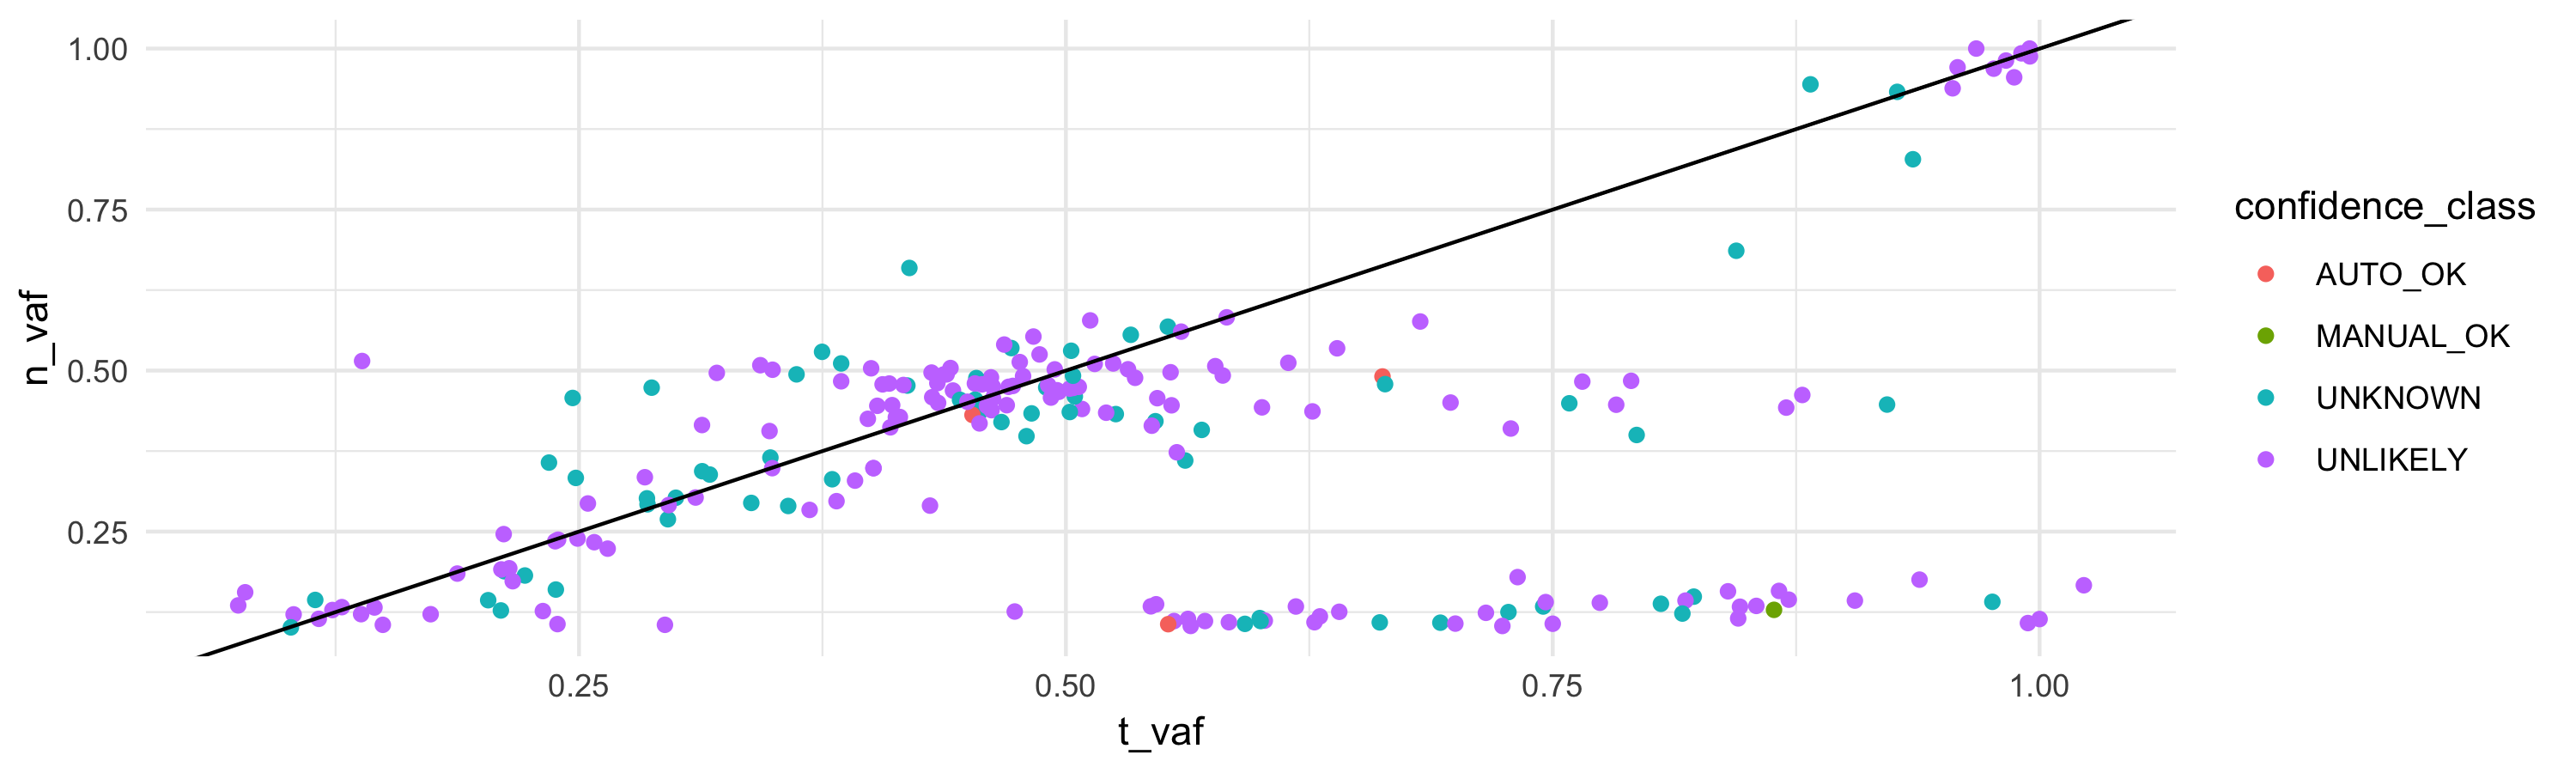

In [9]:
ggplot(impact[impact$n_vaf > 0.1,]) + geom_point(aes(t_vaf, n_vaf, color = confidence_class)) +
                                      geom_abline(intercept = 0, slope = 1)

`n_vaf` should always be 0 but small fluctuations are authorized, however, some values are really huge. How can some mutations have such a high `n_vaf`, even sometime higher than their `t_vaf`? Most of them are considered as `UNKNOWN` or `UNLIKELY` though.  
**The mutations were kept in the dataset.**

In [10]:
addmargins(table(impact[impact$n_vaf > 0.1,]$confidence_class))
nrow(impact[impact$n_vaf > 0.5,])
nrow(impact[impact$n_vaf > 0.9,])


  AUTO_OK MANUAL_OK   UNKNOWN  UNLIKELY       Sum 
        3         1        64       154       222 

[1] 40

[1] 11

In [11]:
summary(impact$t_vaf[impact$n_vaf > 0.1])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0750  0.3700  0.4829  0.5146  0.6371  1.0227 

Notice: this issue and the previous one are not related, see the `n_vaf` for the low `n_depth`:

In [12]:
impact[impact$n_depth == 0,]$n_vaf
impact[impact$n_depth <= 10,]$n_vaf

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

[1] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [10] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [19] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [28] 0.00000 0.00000 0.00000 0.00000 1.00000 0.00000 0.00000 0.00000 0.00000
 [37] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [46] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [55] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [64] 0.00000 0.00000 0.00000 0.12500 0.00000 0.00000 0.00000 0.00000 0.00000
 [73] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [82] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 [91] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[100] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[109] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[118] 0.00000 0.00000 0.00000 0.00000 0.16667 0.00000 0.00000 0.00000 0.00000
[127] 0.00000 0.00000 0.00000 0.11111 0.00000 0.00000 0.00000 0.00000 0.00000
[136] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[145] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[154] 0.00000 0.00000 0.00000 0.00000 0.00000 0.11111 0.00000 0.00000 0.00000
[163] 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
[172] 0.00000 0.00000 0.10000 0.00000

No correlation found with gene, `confidence_class`, `Variant_Type` or `Consequence`:

[1] "Number of different genes:  91"


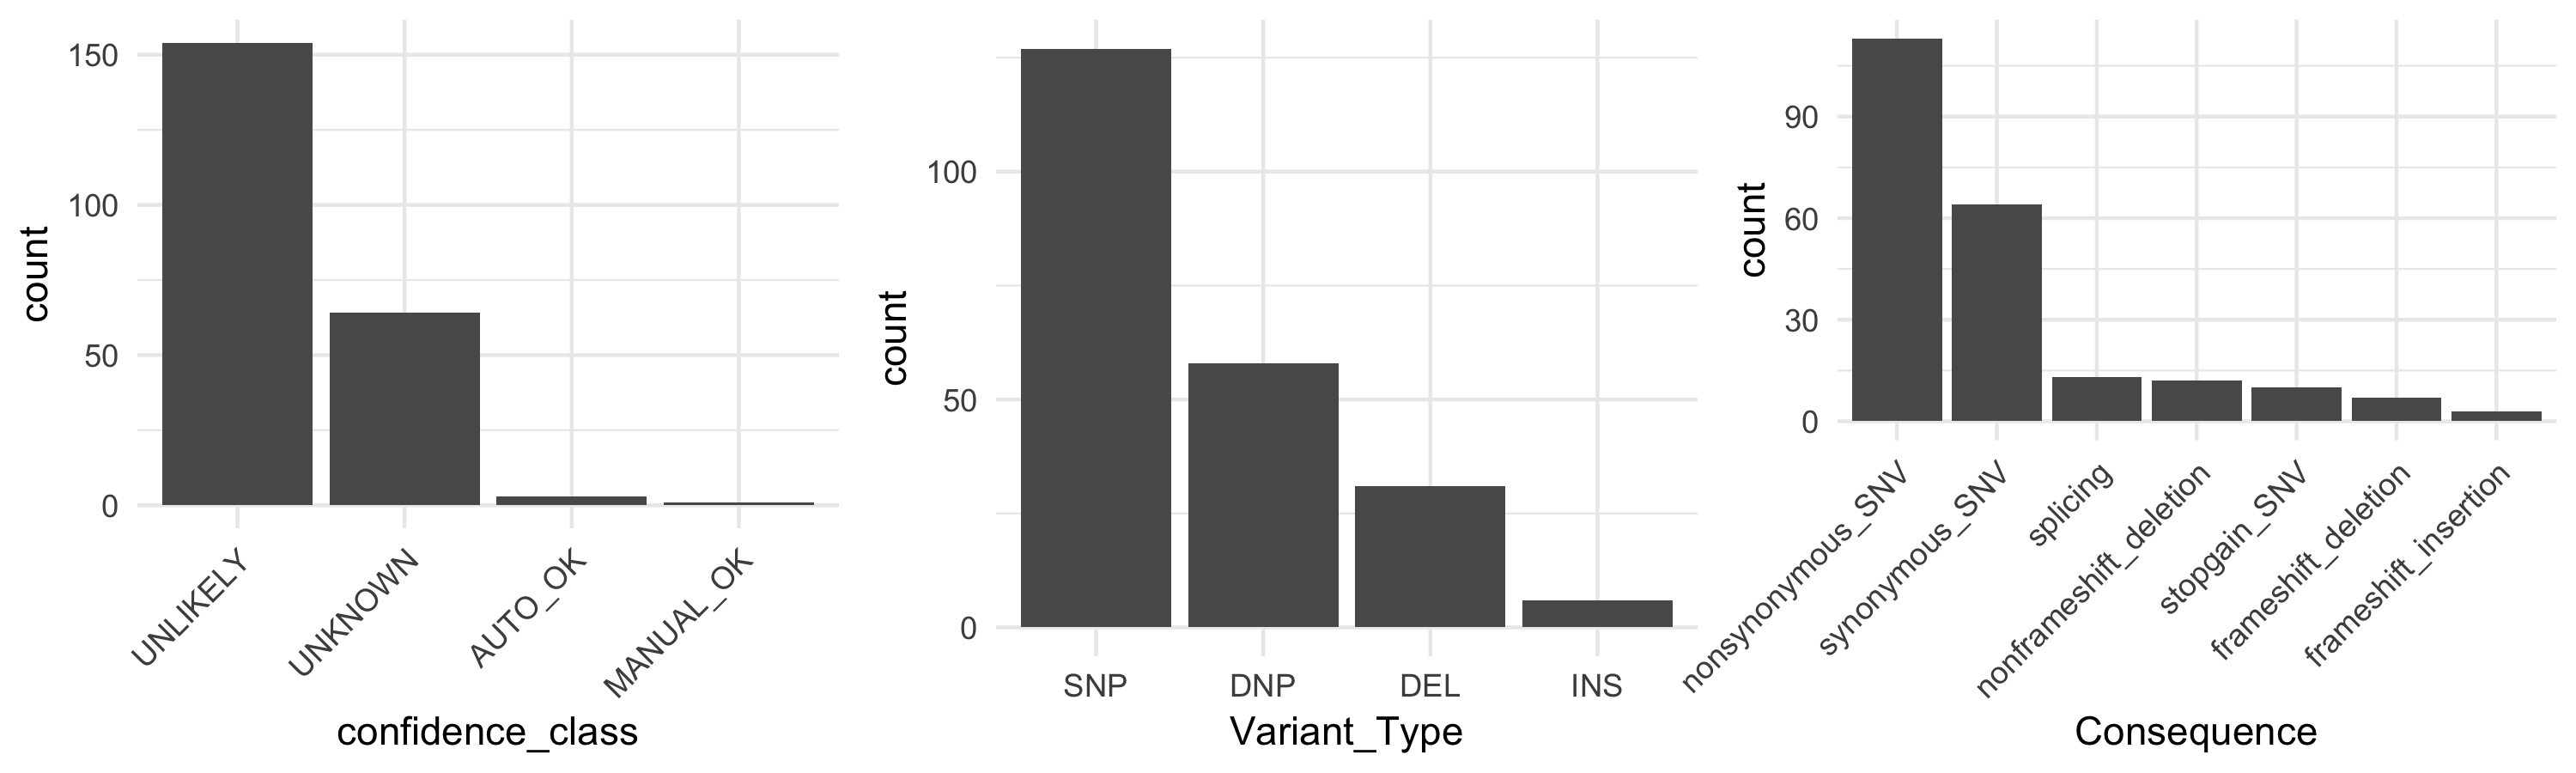

In [13]:
get_possible_correlations(impact[impact$n_vaf > 0.1,])

See under the five mutations with a positive `confidence_class` (e.g. `AUTO_OK` or `MANUAL_OK`), some have `t_vaf` $\approx$ `n_vaf` (see 2nd row) but some even have `t_vaf < n_vaf` (see 3rd row).

In [14]:
impact[impact$n_vaf > 0.1 & impact$confidence_class %in% c("AUTO_OK", "MANUAL_OK"),
       c("t_vaf", "n_vaf", "Hugo_Symbol","HGVSp_Short", "Consequence", "Variant_Type", "confidence_class")]

,t_vaf,n_vaf,Hugo_Symbol,HGVSp_Short,Consequence,Variant_Type,confidence_class
107554,0.66258,0.49085,TP53,p.R213Q,nonsynonymous_SNV,DNP,AUTO_OK
112798,0.45205,0.43109,SOX17,p.M270L,nonsynonymous_SNV,DNP,AUTO_OK
132696,0.86364,0.12849,NF1,p.Q786*,stopgain_SNV,SNP,MANUAL_OK
224852,0.55255,0.10624,CSF3R,p.D702N,nonsynonymous_SNV,SNP,AUTO_OK


## One sample has 2983 mutations, mostly `synonymous_SNV`

<font color='red'> **Decision:** The decision has been made to remove this patient from the dataset. </font>

In [15]:
# construct a dataframe giving the number of mutations per sample
tumor_summary <- as.data.frame(table(impact$Tumor_Sample_Barcode))
colnames(tumor_summary) <- c("Tumor_Sample_Barcode", "number_of_mutations")
tail(tumor_summary)

,Tumor_Sample_Barcode,number_of_mutations
22995,P-0029283-T01-IM6,2
22996,P-0029284-T01-IM6,5
22997,P-0029285-T01-IM6,6
22998,P-0029286-T01-IM6,2
22999,P-0029287-T01-IM6,4
23000,P-0029288-T01-IM6,7


Only one sample presented more than 800 mutations, below are some informations about the hypermutated tumor sample with 2983 mutations (`Tumor_Sample_Barcode = P-0025368-T01-IM6`), it presents mostly `synonymous_SNV` mutations classed as `UNKNOWN`. These mutations represent $2,983/251,858 \approx 1.18\%$ of the mutations we have. Why does this patient have such a high mutation burden, is it an error or an highly-hypermutated sample? Why are the `synonymous_SNV` so represented in this sample?

[1] 2983

[1] 251858

[1] "Number of different genes:  188"


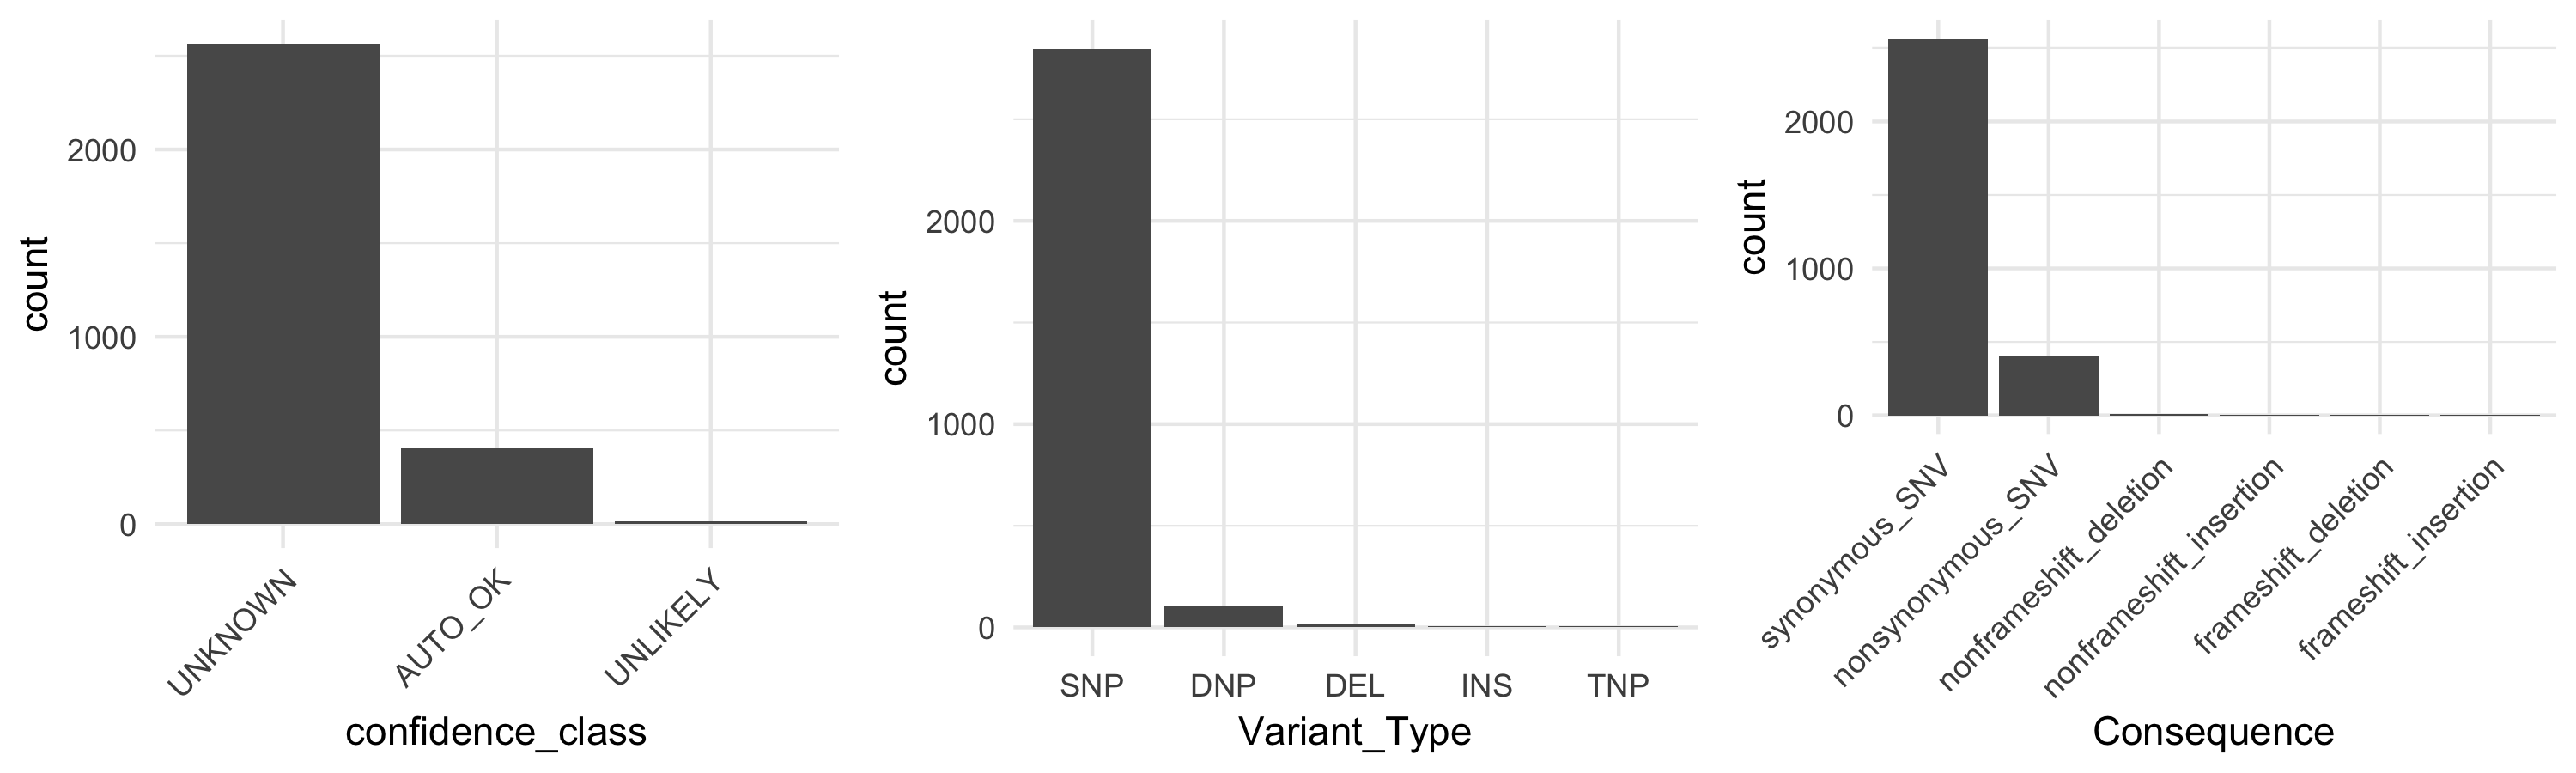

In [16]:
nrow(impact[impact$Tumor_Sample_Barcode == "P-0025368-T01-IM6",])
nrow(impact)
get_possible_correlations(impact[impact$Tumor_Sample_Barcode == "P-0025368-T01-IM6",])

## The `Consequence` feature is sometimes inconsistent with `Variant_Type` and `HGVSp_Short`

<font color='red'> **Decision:** The decision has been made to reclassify the wrongly classified mutations over the `Consequence` feature. It is now consistant with `Variant_Type` but also with `HGVSp_Short` (useful to add OncoKB annotations later). </font>

This section is repetitive and not so easy to read, we advise to look depeer only if interested in this specific topic.

In [17]:
# old version [30/07/18]
get_cleaned_impact <- function(data_folder_name) {

  # [+35 features, +588,547 rows] get the original dataset
  impact <- read.table(paste0(data_folder_name, "/all_IMPACT_mutations_180508.txt"), sep = "\t", stringsAsFactors = FALSE, header = TRUE)


  # [-7 features] remove the unique-value features
  impact[, c("Entrez_Gene_Id",
             "Center",
             "NCBI_Build",
             "Strand",
             "dbSNP_RS",
             "Matched_Norm_Sample_Barcode",
             "variant_status")] <- NULL


  # [-3 features] remove the redundant features
  impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- NULL


  # [-322,796 rows] remove the non-interesting mutations
  impact <- impact[impact$Consequence %in% c("stopgain_SNV",
                                             "splicing",
                                             "nonsynonymous_SNV",
                                             "nonframeshift_insertion",
                                             "nonframeshift_deletion",
                                             "frameshift_insertion",
                                             "frameshift_deletion",
                                             "synonymous_SNV"),]


  # [-12,975 rows] remove the contaminated rows
  impact <- impact[impact$minor_contamination <= 0.01,]
  # [-1 feature] remove the minor_contamination feature
  impact["minor_contamination"] <- NULL


  # [-373 rows] remove the rows having n_depth < 20
  impact <- impact[impact$n_depth >= 20,]


  # [-46 rows] remove the rows having impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count
  impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]


  # [+1 feature] create a mutation key feature to idenfity unique mutations
  impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
  # [+1 feature] create a sample mutation key feature to idenfity unique rows
  impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')


  # [~ 7501 rows] replace the wrong Hugo symbols with the good ones
  old_Hugo_Symbol = c('MLL3', 'PAK7', 'RFWD2', 'MYCL1', 'MLL2', 'MLL', 'FAM46C', 'MRE11A', 'PARK2', 'FAM175A',
                      'TCEB1', 'WHSC1', 'WHSC1L1', 'FAM58A', 'SETD8', 'MLL4')
  new_Hugo_Symbol = c('KMT2C', 'PAK5', 'COP1', 'MYCL', 'KMT2D', 'KMT2A', 'TENT5C', 'MRE11', 'PRKN', 'ABRAXAS1',
                      'ELOC', 'NSD2', 'NSD3', 'CCNQ', 'KMT5A', 'KMT2B')
  old_symbols <- which(impact$Hugo_Symbol %in% old_Hugo_Symbol)
  impact$Hugo_Symbol[old_symbols] <- new_Hugo_Symbol[match(impact$Hugo_Symbol[old_symbols], old_Hugo_Symbol)]

  # [~ 1334 rows] replace "CDKN2Ap16INK4A" by "CDKN2A"
  impact$Hugo_Symbol[impact$Hugo_Symbol == "CDKN2Ap16INK4A"] <- "CDKN2A"
  # [-808 rows] delete the "CDKN2Ap14ARF" already read in the classic read frame (in "CDKN2Ap16INK4A")
  impact <- impact %>% filter(! (Hugo_Symbol == "CDKN2Ap14ARF" & mut_key %in% impact$mut_key[impact$Hugo_Symbol == "CDKN2A"]))


  # [-2979 rows] remove the hypermutated patient
  impact <- impact[impact$Tumor_Sample_Barcode != "P-0025368-T01-IM6",]


  # [-57 rows] remove the duplicated mutations
  impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
  impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth))
  impact_redundant_to_delete <- impact_redundant_to_delete %>% group_by(sample_mut_key) %>% filter(t_vaf == min(t_vaf))
  impact <- impact %>% filter(! (sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                                 t_depth %in% impact_redundant_to_delete$t_depth &
                                 t_vaf %in% impact_redundant_to_delete$t_vaf))


  # [~ every rows] replace the occurence_in_normals feature by frequency_in_normals
  impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
  impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                        function(s) as.double(strsplit(s, split = ';')[[1]][2]))
  impact$occurence_in_normals <- NULL


  # [~ 24 rows] set all the `synonymous_SNV` as "UNKNOWN" for consistancy (24 were classified as "UNLIKELY")
  impact$confidence_class[impact$Consequence == "synonymous_SNV"] <- "UNKNOWN"


  return (impact)
}

In [18]:
impact <- get_cleaned_impact("../../../data") # an old version before this problem was solved [30/07/18] - see hiden cell above

In [19]:
get_consequence <- function(impact, Consequence_name) {
    return (impact[impact$Consequence %in% Consequence_name,
                   c("Variant_Type", "HGVSp_Short", "cDNA_change", "Start_Position", "End_Position",
                     "Reference_Allele", "Tumor_Seq_Allele2", "sample_mut_key", "Consequence")])
}

### `Variant_Type`

In [20]:
is_frameshift <- function(Tumor_Seq_Allele2, Reference_Allele) {
    # we nee to add gsub('-', '', ...) because we have '-' instead of '' when there is no base pair to show
    return ((nchar(gsub('-', '', Tumor_Seq_Allele2)) - nchar(gsub('-', '', Reference_Allele))) %% 3 != 0)
}

This section aims to reclassify and clean the mutations depending on their `Variant_Type` and if they are frameshift or not, a resume of the modifications is done in the last subpart. There is two types of error:
* A wrong `Variant_Type`: for example we would expect every `frameshift_deletion` to be have a `DEL` `Variant_Type`:

In [21]:
table(impact$Variant_Type, impact$Consequence)

     
      frameshift_deletion frameshift_insertion nonframeshift_deletion
  DEL               16773                   60                   4209
  DNP                   0                    0                      1
  INS                   8                 6428                      2
  SNP                   3                    1                      4
  TNP                   1                    0                      0
     
      nonframeshift_insertion nonsynonymous_SNV splicing stopgain_SNV
  DEL                      19                77     1842          570
  DNP                       0              2428      150          276
  INS                     901                29      184          313
  SNP                       0            139249     7198        17574
  TNP                       0               160        2           30
     
      synonymous_SNV
  DEL              0
  DNP             23
  INS              0
  SNP          49987
  TNP              0

* A wrong frameshift/nonframeshift classification:

In [22]:
nrow(impact[impact$Consequence == "frameshift_insertion"   ,] %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "frameshift_deletion"    ,] %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "nonframeshift_insertion",] %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "nonframeshift_deletion" ,] %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))

[1] 71

[1] 75

[1] 3

[1] 31

The following function reclassifies the mutations as frameshift/nonframeshift insertion/deletion according to:
* their `Variant_Type`
* if they are frameshift or not

See the next subpart `nonsynonymous_SNV` to have an example of how it is used.

In [23]:
reclassify <- function(data, impact) {
    to_frameshift_insertion    <- data %>%
                                  filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "INS")
    to_frameshift_deletion     <- data %>%
                                  filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "DEL")
    to_nonframeshift_insertion <- data %>%
                                  filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "INS")
    to_nonframeshift_deletion  <- data %>%
                                  filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "DEL")
    
    a <- nrow(to_frameshift_insertion)
    b <- nrow(to_frameshift_deletion)
    c <- nrow(to_nonframeshift_insertion)
    d <- nrow(to_nonframeshift_deletion)
    
    print(sprintf("Reclassified as frameshift_insertion   : %d", a))
    print(sprintf("Reclassified as frameshift_deletion    : %d", b))
    print(sprintf("Reclassified as nonframeshift_insertion: %d", c))
    print(sprintf("Reclassified as nonframeshift_deletion : %d", d))
    print(sprintf("Total                                  : %d", a + b + c + d))

    impact$Consequence[impact$sample_mut_key %in% to_frameshift_insertion   $sample_mut_key] <- "frameshift_insertion"
    impact$Consequence[impact$sample_mut_key %in% to_frameshift_deletion    $sample_mut_key] <- "frameshift_deletion"
    impact$Consequence[impact$sample_mut_key %in% to_nonframeshift_insertion$sample_mut_key] <- "nonframeshift_insertion"
    impact$Consequence[impact$sample_mut_key %in% to_nonframeshift_deletion $sample_mut_key] <- "nonframeshift_deletion"

    return (impact)
}

In [24]:
print_reclassification <- function(data, impact, which = "frameshift_insertion") {
    if (which == "frameshift_insertion")
        head(data %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "INS"))
    else if (which == "frameshift_deletion")
        head(data %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "DEL"))
    else if (which == "nonframeshift_insertion")
        head(data %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "INS"))
    else if (which == "nonframeshift_deletion")
        head(data %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele) & Variant_Type == "DEL"))
}

####  `nonsynonymous_SNV`

In [25]:
nonsynonymous_SNV <- get_consequence(impact, "nonsynonymous_SNV")
table(nonsynonymous_SNV$Variant_Type)


   DEL    DNP    INS    SNP    TNP 
    77   2428     29 139249    160 

There shouldn't be any `DEL` or `INS`. If we would reclassify the mutations, the following mutations would be reclassified as `frameshift_insertion`:

In [26]:
print_reclassification(nonsynonymous_SNV, impact, "frameshift_insertion")

Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
INS,p.M209Ifs*,c.627delinsTA,135797241,135797242,G,AT,P-0003146-T01-IM5_9_135797241_G_AT,nonsynonymous_SNV
INS,p.M508fs,c.1523_1533delinsGGGCTTTAGCGG,58740618,58740619,GGACCAAAAA,GGCTTTAGCGC,P-0005028-T01-IM5_17_58740618_GGACCAAAAA_GGCTTTAGCGC,nonsynonymous_SNV
INS,p.A1789fs,c.5365_5367delinsACCT,27105754,27105755,CC,CCT,P-0010210-T01-IM5_1_27105754_CC_CCT,nonsynonymous_SNV
INS,p.A1789fs,c.5365_5367delinsACCT,27105754,27105755,CC,CCT,P-0010210-T02-IM5_1_27105754_CC_CCT,nonsynonymous_SNV
INS,p.N822Sfs*3,c.2463_2464delinsTTCAAC,47163662,47163663,T,TTGAA,P-0013638-T01-IM5_3_47163662_T_TTGAA,nonsynonymous_SNV
INS,p.P380fs,c.1139delinsGT,102201787,102201788,-,T,P-0013695-T01-IM5_11_102201787_-_T,nonsynonymous_SNV


We decide to reclassify everything:

In [27]:
impact <- reclassify(nonsynonymous_SNV, impact)

[1] "Reclassified as frameshift_insertion   : 13"
[1] "Reclassified as frameshift_deletion    : 38"
[1] "Reclassified as nonframeshift_insertion: 16"
[1] "Reclassified as nonframeshift_deletion : 39"
[1] "Total                                  : 106"


In [28]:
nonsynonymous_SNV <- get_consequence(impact, "nonsynonymous_SNV")
table(nonsynonymous_SNV$Variant_Type)


   DNP    SNP    TNP 
  2428 139249    160 

####  `synonymous_SNV`

In [29]:
synonymous_SNV <- get_consequence(impact, "synonymous_SNV")
table(nonsynonymous_SNV$Variant_Type)


   DNP    SNP    TNP 
  2428 139249    160 

####  `frameshift_insertion`

In [30]:
frameshift_insertion <- get_consequence(impact, "frameshift_insertion")
table(frameshift_insertion$Variant_Type)

# number of nonframeshift wrongly classified as frameshift
nrow(frameshift_insertion %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


 DEL  INS  SNP 
  60 6441    1 

[1] 71

In [31]:
impact <- reclassify(frameshift_insertion, impact)

[1] "Reclassified as frameshift_insertion   : 6427"
[1] "Reclassified as frameshift_deletion    : 4"
[1] "Reclassified as nonframeshift_insertion: 14"
[1] "Reclassified as nonframeshift_deletion : 56"
[1] "Total                                  : 6501"


In [32]:
frameshift_insertion <- get_consequence(impact, "frameshift_insertion")
frameshift_insertion[frameshift_insertion$Variant_Type != "INS",]

,Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
26606,SNP,p.E298fs,c.892delinsCA,13051633,13051633,G,A,P-0002209-T02-IM5_19_13051633_G_A,frameshift_insertion


We will remove it.

In [33]:
impact <- impact[impact$sample_mut_key != "P-0002209-T02-IM5_19_13051633_G_A",]

In [34]:
frameshift_insertion <- get_consequence(impact, "frameshift_insertion")
table(frameshift_insertion$Variant_Type)
nrow(frameshift_insertion %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


 INS 
6427 

[1] 0

####  `frameshift_deletion`

In [35]:
frameshift_deletion <- get_consequence(impact, "frameshift_deletion")
table(frameshift_deletion$Variant_Type)
nrow(frameshift_deletion %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


  DEL   INS   SNP   TNP 
16815     8     3     1 

[1] 75

In [36]:
impact <- reclassify(frameshift_deletion, impact)

[1] "Reclassified as frameshift_insertion   : 6"
[1] "Reclassified as frameshift_deletion    : 16746"
[1] "Reclassified as nonframeshift_insertion: 2"
[1] "Reclassified as nonframeshift_deletion : 69"
[1] "Total                                  : 16823"


In [37]:
frameshift_deletion <- get_consequence(impact, "frameshift_deletion")
frameshift_deletion[frameshift_deletion$Variant_Type != "DEL",]

,Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
18040,SNP,p.K1057fs,c.3171_3172delinsT,108143466,108143466,A,T,P-0002955-T01-IM3_11_108143466_A_T,frameshift_deletion
30523,SNP,p.L1413H,c.4238T>A,120468201,120468201,A,T,P-0004486-T01-IM5_1_120468201_A_T,frameshift_deletion
40729,SNP,p.S1963fs,c.5887_5927delinsATCACCTCAATAGCATCGCTGGTCTAAGAAACCTGTGAC,2225414,2225414,ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG,CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG,P-0005565-T01-IM5_17_2225414_ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG_CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG,frameshift_deletion
156734,TNP,p.T1301Pfs*4,c.3900_3901delinsC,112175190,112175192,ATA,ACA,P-0019100-T01-IM6_5_112175190_ATA_ACA,frameshift_deletion


We will remove all except the second one, that we reclassify as `nonsynonymous_SNV`.

In [38]:
impact <- impact[! impact$sample_mut_key %in% c("P-0002955-T01-IM3_11_108143466_A_T",
                                                "P-0005565-T01-IM5_17_2225414_ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG_CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG",
                                                "P-0019100-T01-IM6_5_112175190_ATA_ACA"),]
impact$Consequence[impact$sample_mut_key == "P-0004486-T01-IM5_1_120468201_A_T"] <- "synonymous_SNV"

In [39]:
frameshift_deletion <- get_consequence(impact, "frameshift_deletion")
table(frameshift_deletion$Variant_Type)
nrow(frameshift_deletion %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


  DEL 
16746 

[1] 0

#### `nonframeshift_insertion`

In [40]:
nonframeshift_insertion <- get_consequence(impact, "nonframeshift_insertion")
table(nonframeshift_insertion$Variant_Type)
nrow(nonframeshift_insertion %>% filter(is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


DEL INS 
 19 933 

[1] 3

In [41]:
impact <- reclassify(nonframeshift_insertion, impact)

[1] "Reclassified as frameshift_insertion   : 3"
[1] "Reclassified as frameshift_deletion    : 0"
[1] "Reclassified as nonframeshift_insertion: 930"
[1] "Reclassified as nonframeshift_deletion : 19"
[1] "Total                                  : 952"


In [42]:
nonframeshift_insertion <- get_consequence(impact, "nonframeshift_insertion")
table(nonframeshift_insertion$Variant_Type)
nrow(nonframeshift_insertion %>% filter(is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


INS 
930 

[1] 0

#### `nonframeshift_deletion`

In [43]:
nonframeshift_deletion <- get_consequence(impact, "nonframeshift_deletion")
table(nonframeshift_deletion$Variant_Type)
nrow(nonframeshift_deletion %>% filter(is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


 DEL  DNP  INS  SNP 
4392    1    2    4 

[1] 31

In [44]:
impact <- reclassify(nonframeshift_deletion, impact)

[1] "Reclassified as frameshift_insertion   : 1"
[1] "Reclassified as frameshift_deletion    : 30"
[1] "Reclassified as nonframeshift_insertion: 1"
[1] "Reclassified as nonframeshift_deletion : 4362"
[1] "Total                                  : 4394"


In [45]:
nonframeshift_deletion <- get_consequence(impact, "nonframeshift_deletion")
nonframeshift_deletion[nonframeshift_deletion$Variant_Type != "DEL",]

,Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
19303,SNP,p.E409_E410delinsKK,c.1225_1228delinsAAAA,41988433,41988433,G,A,P-0003132-T01-IM5_15_41988433_G_A,nonframeshift_deletion
71670,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0009326-T01-IM5_17_74732956_G_A,nonframeshift_deletion
84110,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0010818-T01-IM5_17_74732956_G_A,nonframeshift_deletion
97760,DNP,p.E198_S392del,c.594_595delinsTT,7578254,7578255,CT,AA,P-0012684-T01-IM5_17_7578254_CT_AA,nonframeshift_deletion
116230,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0010818-T02-IM6_17_74732956_G_A,nonframeshift_deletion


We will reclassify all as `nonsynonymous_SNV`.

In [46]:
impact$Consequence[impact$sample_mut_key %in% c("P-0003132-T01-IM5_15_41988433_G_A",
                                                "P-0009326-T01-IM5_17_74732956_G_A",
                                                "P-0010818-T01-IM5_17_74732956_G_A",
                                                "P-0012684-T01-IM5_17_7578254_CT_AA",
                                                "P-0010818-T02-IM6_17_74732956_G_A")] <- "nonsynonymous_SNV"

In [47]:
nonframeshift_deletion <- get_consequence(impact, "nonframeshift_deletion")
table(nonframeshift_deletion$Variant_Type)
nrow(nonframeshift_deletion %>% filter(is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))


 DEL 
4362 

[1] 0

#### Resume of the operations

In [48]:
impact <- get_cleaned_impact("../../../data") # the old version [30/07/18]

In [49]:
# [-4 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
impact <- impact[! impact$sample_mut_key %in% c("P-0002209-T02-IM5_19_13051633_G_A",
                                                "P-0002955-T01-IM3_11_108143466_A_T",
                                                "P-0005565-T01-IM5_17_2225414_ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG_CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG",
                                                "P-0019100-T01-IM6_5_112175190_ATA_ACA"),]
# [~6 rows] reclassify the mutations to `nonsynonymous_SNV`
impact$Consequence[impact$sample_mut_key %in% c("P-0004486-T01-IM5_1_120468201_A_T",
                                                "P-0003132-T01-IM5_15_41988433_G_A",
                                                "P-0009326-T01-IM5_17_74732956_G_A",
                                                "P-0010818-T01-IM5_17_74732956_G_A",
                                                "P-0012684-T01-IM5_17_7578254_CT_AA",
                                                "P-0010818-T02-IM6_17_74732956_G_A")] <- "nonsynonymous_SNV"
# [~311 rows] reclassify the mutations to frameshift/nonframeshift insertion/deletion
consequence_to_reclassify <- c("nonsynonymous_SNV", "frameshift_insertion", "frameshift_deletion",
                               "nonframeshift_insertion", "nonframeshift_deletion")
impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                   impact$Variant_Type == "INS"] <- "frameshift_insertion"
impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                   impact$Variant_Type == "DEL"] <- "frameshift_deletion"
impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                   impact$Variant_Type == "INS"] <- "nonframeshift_insertion"
impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                   impact$Variant_Type == "DEL"] <- "nonframeshift_deletion"

All the issues adressed in this part were solved!

In [50]:
table(impact$Variant_Type, impact$Consequence)
nrow(impact[impact$Consequence == "frameshift_insertion"   ,] %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "frameshift_deletion"    ,] %>% filter(! is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "nonframeshift_insertion",] %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))
nrow(impact[impact$Consequence == "nonframeshift_deletion" ,] %>% filter(  is_frameshift(Tumor_Seq_Allele2, Reference_Allele)))

     
      frameshift_deletion frameshift_insertion nonframeshift_deletion
  DEL               16776                    0                   4362
  DNP                   0                    0                      0
  INS                   0                 6437                      0
  SNP                   0                    0                      0
  TNP                   0                    0                      0
     
      nonframeshift_insertion nonsynonymous_SNV splicing stopgain_SNV
  DEL                       0                 0     1842          570
  DNP                       0              2429      150          276
  INS                     931                 0      184          313
  SNP                       0            139254     7198        17574
  TNP                       0               160        2           30
     
      synonymous_SNV
  DEL              0
  DNP             23
  INS              0
  SNP          49987
  TNP              0

[1] 0

[1] 0

[1] 0

[1] 0

### `HGVSp_Short`

This sections aims to reclassify and clean the mutations depending on their `HGVSp_Short`, a resume of the modifications is done in the last subpart. There is different types of errors, we will use three different ways to correct them:
* Removing the sample because its `HGVSp_Short` doesn't fit with its `Variant_Type` (for example a `SNP` having a frameshift `HGVSp_Short`: we don't know which `Consequence` it should have).
* Reclassify the sample because its `HGVSp_Short` correspond to another `Consequence` (and the `Variant_Type` complies with this `Consequence`)
* Modify the `HGVSp_Short` because there is a typo

We will keep track of the three different modifications to be made with the following vectors:

In [51]:
sample_mut_keys_to_remove   <- c() # store the sample mutation keys to remove

sample_mut_keys_replace_Consequence <- c() # store the sample mutation keys where the Consequence needs to be replaced
new_Consequence                     <- c() # store the new Consequence for the previous sample mutation keys

sample_mut_keys_replace_HGVSp_Short <- c() # store the sample mutation keys where the HGVSp_Short needs to be replaced
new_HGVSp_Short                     <- c() # store the new HGVSp_Short for the previous sample mutation keys

In [52]:
get_grep <- function(pattern, data, feature_name) {
    return (data[grep(pattern, data[,feature_name]),])
}

The following function removes the grep pattern from the given dataset, see next subpart for the utilisation.

In [53]:
remove_grep <- function(pattern, data, feature_name) {
    to_search <- data[,feature_name]
    
    print(sprintf("%6d rows removed, %5d rows left (rm ~ %s)",
                  length(to_search[grep(pattern, to_search)]),
                  length(to_search[grep(pattern, to_search, invert = TRUE)]),
                  toString(head(to_search[grep(pattern, to_search)], 3))))
    
    return (data[grep(pattern, to_search, invert = TRUE),])
}

####  `nonsynonymous_SNV`

In [54]:
nonsynonymous_SNV <- get_consequence(impact, "nonsynonymous_SNV")

In [55]:
patterns = c("^p\\.[A-Z][0-9]{1,4}[A-Z]$",                          # single acid substitution       -> p.T256P 
             "^p\\.[A-Z]{2}[0-9]{1,4}[A-Z]{2}$",                    # double acid substitution       -> p.QH192HY
             "^p\\.[A-Z]{3}[0-9]{1,4}[A-Z]{3}$",                    # triple acid substitution       -> p.EGD60RVT
             "^p\\.M1\\?",                                          # start codon deletion           -> p.M1?
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]{2}$") # other double acid substitution -> p.Q1257_P1258delinsHS

for (pat in patterns)
    nonsynonymous_SNV <- remove_grep(pat, nonsynonymous_SNV, "HGVSp_Short")

[1] "141482 rows removed,   361 rows left (rm ~ p.T256P, p.I298M, p.R2431M)"
[1] "    64 rows removed,   297 rows left (rm ~ p.LG1361FW, p.QH192HY, p.LG1361FW)"
[1] "     5 rows removed,   292 rows left (rm ~ p.EGD60RVT, p.FPS227SPA, p.EKL2145GSC)"
[1] "    56 rows removed,   236 rows left (rm ~ p.M1?, p.M1?, p.M1?)"
[1] "   194 rows removed,    42 rows left (rm ~ p.Q1257_P1258delinsHS, p.Q120_R121delinsHC, p.G451_S452delinsEG)"


In [56]:
# Verify that the first and last protein acids are different for single, double and triple substitution
nrow(nonsynonymous_SNV %>% filter(grepl(patterns[1], HGVSp_Short) &
                                  substr(HGVSp_Short, 3, 3) == substr(HGVSp_Short, nchar(HGVSp_Short)  , nchar(HGVSp_Short))))
nrow(nonsynonymous_SNV %>% filter(grepl(patterns[2], HGVSp_Short) &
                                  substr(HGVSp_Short, 3, 4) == substr(HGVSp_Short, nchar(HGVSp_Short)-1, nchar(HGVSp_Short))))
nrow(nonsynonymous_SNV %>% filter(grepl(patterns[3], HGVSp_Short) &
                                  substr(HGVSp_Short, 3, 5) == substr(HGVSp_Short, nchar(HGVSp_Short)-2, nchar(HGVSp_Short))))

[1] 0

[1] 0

[1] 0

##### Reclassify the `stopgain`

In [57]:
patterns = c("^p\\.[A-Z][0-9]{1,4}\\*$",                             # stopgain         -> p.E302*
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]*\\*$") # complex stopgain -> p.N847_C848delins*

for (pat in patterns) {
    # store the modification
    grepped <- get_grep(pat, nonsynonymous_SNV, "HGVSp_Short")
    sample_mut_keys_replace_Consequence <- c(sample_mut_keys_replace_Consequence, grepped$sample_mut_key)
    new_Consequence <- c(new_Consequence, rep("stopgain", length(grepped$sample_mut_key)))
    
    nonsynonymous_SNV <- remove_grep(pat, nonsynonymous_SNV, "HGVSp_Short")
}

[1] "    14 rows removed,    28 rows left (rm ~ p.R193*, p.H823*, p.L1769*)"
[1] "    10 rows removed,    18 rows left (rm ~ p.M519_E520delinsI*, p.M1613_Q1614delinsI*, p.E537_Q538delinsD*)"


##### Remove the wrong one

We remove the mutations having an `HGVSp_Short` not compliant to a `non_synonymous_SNV` `HGVSp_Short`.

In [58]:
to_remove <- c("P-0006060-T01-IM5_12_57864689_GG_TT",
               "P-0009326-T01-IM5_17_74732956_G_A",
               "P-0010818-T01-IM5_17_74732956_G_A",
               "P-0012684-T01-IM5_17_7578254_CT_AA",
               "P-0013011-T01-IM5_17_7577082_CC_AA",
               "P-0010818-T02-IM6_17_74732956_G_A",
               "P-0005243-T01-IM5_X_76938041_CC_GA",
               "P-0006368-T01-IM5_2_47707974_GG_TT",
               "P-0018327-T01-IM6_7_70349260_AAAG_CAAT",
               "P-0027607-T01-IM6_17_27097630_CGCCCCTCCGGCTCCCCCAACCCATCT_GGGTTGGGGGAGCCGGAGGGGCGGGCA")
nonsynonymous_SNV[nonsynonymous_SNV$sample_mut_key %in% to_remove,]
nonsynonymous_SNV <- nonsynonymous_SNV[! nonsynonymous_SNV$sample_mut_key %in% to_remove,]

# store the modification
sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, to_remove)

,Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
37763,DNP,p.M902_E903QdelinsIQ,c.2706_2707delinsTC,76938041,76938042,CC,GA,P-0005243-T01-IM5_X_76938041_CC_GA,nonsynonymous_SNV
44597,DNP,p.M722_D723fs,c.2166_2167delinsTT,57864689,57864690,GG,TT,P-0006060-T01-IM5_12_57864689_GG_TT,nonsynonymous_SNV
47748,DNP,p.M866I_T934delinsI,c.2598_2599delinsTT,47707974,47707975,GG,TT,P-0006368-T01-IM5_2_47707974_GG_TT,nonsynonymous_SNV
71670,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0009326-T01-IM5_17_74732956_G_A,nonsynonymous_SNV
84110,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0010818-T01-IM5_17_74732956_G_A,nonsynonymous_SNV
97760,DNP,p.E198_S392del,c.594_595delinsTT,7578254,7578255,CT,AA,P-0012684-T01-IM5_17_7578254_CT_AA,nonsynonymous_SNV
100807,DNP,p.E285_E286del,c.855_856delinsTT,7577082,7577083,CC,AA,P-0013011-T01-IM5_17_7577082_CC_AA,nonsynonymous_SNV
116230,SNP,p.96L,c.287C>T,74732956,74732956,G,A,P-0010818-T02-IM6_17_74732956_G_A,nonsynonymous_SNV
148663,SNP,p.K1078_Ala1102delinsQ,c.3232_3235delinsCAAT,70349260,70349260,AAAG,CAAT,P-0018327-T01-IM6_7_70349260_AAAG_CAAT,nonsynonymous_SNV
233946,SNP,p.EDGLGEPEGR59DARPSGSPNP,c.177_203delinsTGCCCGCCCCTCCGGCTCCCCCAACCC,27097630,27097630,CGCCCCTCCGGCTCCCCCAACCCATCT,GGGTTGGGGGAGCCGGAGGGGCGGGCA,P-0027607-T01-IM6_17_27097630_CGCCCCTCCGGCTCCCCCAACCCATCT_GGGTTGGGGGAGCCGGAGGGGCGGGCA,nonsynonymous_SNV


##### Correct the others

In [59]:
new <- c("p.C189_A190delinsWH",
         "p.D626_G627delinsEC",
         "p.E680_D681delinsDY",
         "p.H1047_H1048delinsRR",
         "p.L306_A307delinsFS",
         "p.Q821_I822delinsHM",
         "p.V224_Y225delinsLC",
         "p.H1047_H1048delinsRR")
data.frame(nonsynonymous_SNV$HGVSp_Short, new)

# store the modification
sample_mut_keys_replace_HGVSp_Short <- c(sample_mut_keys_replace_HGVSp_Short, nonsynonymous_SNV$sample_mut_key)
new_HGVSp_Short <- c(new_HGVSp_Short, new)

nonsynonymous_SNV.HGVSp_Short,new
pp.C189_A190delinsWH,p.C189_A190delinsWH
p.626D_627GdelinsEC,p.D626_G627delinsEC
p.E680D_D681YdelinsDY,p.E680_D681delinsDY
p.H1047_His1048delinsRR,p.H1047_H1048delinsRR
L306_A307delinsFS,p.L306_A307delinsFS
p.Q821_I822delinHM,p.Q821_I822delinsHM
p.V224_Y225LC,p.V224_Y225delinsLC
p.H1047_His1048delinsRR,p.H1047_H1048delinsRR


####  `synonymous_SNV`

In [60]:
synonymous_SNV <- get_consequence(impact, "synonymous_SNV")

In [61]:
patterns = c("^p\\.([A-Z])[0-9]{1,4}\\1$",    # single synonymous acid substitution -> p.P1618P
             "^p\\.([A-Z]{2})[0-9]{1,4}\\1$", # double synonymous acid substitution -> p.HL218HL
             "^p\\.\\*[0-9]{1,4}\\*$",        # other synonymous acid substitution  -> p.*1461*
             "^p\\.=$")                       # other synonymous acid substitution  -> p.=

for (pat in patterns)
    synonymous_SNV <- remove_grep(pat, synonymous_SNV, "HGVSp_Short")

[1] " 49929 rows removed,    81 rows left (rm ~ p.P1618P, p.L484L, p.L491L)"
[1] "    23 rows removed,    58 rows left (rm ~ p.HL218HL, p.GL1407GL, p.TL742TL)"
[1] "    36 rows removed,    22 rows left (rm ~ p.*1461*, p.*207*, p.*129*)"
[1] "    22 rows removed,     0 rows left (rm ~ p.=, p.=, p.=)"


#### Truncating mutations

The truncating mutations are `splicing`, `stopgain_SNV`, `frameshift_insertion`, `frameshift_deletion`.

In [62]:
truncating <- get_consequence(impact, c("splicing", "stopgain_SNV", "frameshift_insertion", "frameshift_deletion"))

In [63]:
patterns = c("^p\\.[A-Z]{1}[0-9]{1,4}_splice",                       # splicing                -> p.X1370_splice
             "^$",                                                   # other splicing          -> '' (empty string)
             "p\\.\\?$",                                             # other splicing          -> p.?
             "^p\\.[A-Z][0-9]{1,4}\\*$",                             # stopgain                -> p.E302*
             "^p\\.[A-Z]{2}[0-9]{1,4}[A-Z]\\*$",                     # "double" stopgain       -> p.LK669F
             "^p\\.[A-Z]{2}[0-9]{1,4}\\*[A-Z]$",                     # other "double" stopgain -> p.WG110*S
             "^p\\.[A-Z]{3}[0-9]{1,4}[A-Z]{2}\\*$",                  # "triple" stopgain       -> p.LK669F
             "^p\\.[A-Z][0-9]{1,4}X$",                               # other stopgain          -> p.Y477X
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]*\\*$", # complex stopgain        -> p.N847_C848delins*
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}ins\\*$",          # other complex stopgain  -> p.T125_Y126ins*
             "^p\\.[A-Z][0-9]{1,4}delins[A-Z]*\\*$",                 # other complex stopgain  -> p.Q1198delinsLC*
             "^p\\.[A-Z][0-9]{1,4}[A-Z]{0,1}fs$",                    # frameshift simple       -> p.W547fs, p.H634Kfs
             "^p\\.[A-Z][0-9]{1,4}[A-Z]fs\\*[0-9]{1,3}$",            # frameshift complex      -> p.N292Kfs*6
             "^p\\.[A-Z][0-9]{1,4}[A-Z]fs\\*\\?$")                   # frameshift other        -> p.Q290Pfs*?

for (pat in patterns)
    truncating <- remove_grep(pat, truncating, "HGVSp_Short")

[1] "  4372 rows removed, 46980 rows left (rm ~ p.X1370_splice, p.X131_splice, p.X70_splice)"
[1] "  3959 rows removed, 43021 rows left (rm ~ , , )"
[1] "     6 rows removed, 43015 rows left (rm ~ p.?, p.?, p.?)"
[1] " 18931 rows removed, 24084 rows left (rm ~ p.G61*, p.E302*, p.E915*)"
[1] "    22 rows removed, 24062 rows left (rm ~ p.LK669F*, p.EE1780D*, p.QE151H*)"
[1] "    13 rows removed, 24049 rows left (rm ~ p.WG110*S, p.WG110*S, p.CP202*T)"
[1] "     1 rows removed, 24048 rows left (rm ~ p.FRV1741SV*)"
[1] "    33 rows removed, 24015 rows left (rm ~ p.Y477X, p.S1207X, p.Q3489X)"
[1] "    73 rows removed, 23942 rows left (rm ~ p.N847_C848delins*, p.Y386_A387delins*, p.K3401_E3402delins*)"
[1] "     7 rows removed, 23935 rows left (rm ~ p.T125_Y126ins*, p.M239_Y240ins*, p.Q579_Y580ins*)"
[1] "    10 rows removed, 23925 rows left (rm ~ p.Q1198delinsLC*, p.Q69delinsQQQQ*, p.Y120delins*)"
[1] "  5606 rows removed, 18319 rows left (rm ~ p.W547fs, p.A363fs, p.P67fs)"
[1] " 17241 rows 

##### Reclassify the `nonsynonymous_SNV`

In [64]:
patterns = c("^p\\.[A-Z][0-9]{1,4}[A-Z]$",                          # single acid substitution       -> p.T256P 
             "^p\\.M1\\?",                                          # start codon deletion           -> p.M1?
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]{2}$") # other double acid substitution -> p.Q1257_P1258delinsHS

for (pat in patterns) {
    # store the modification
    grepped <- get_grep(pat, truncating[truncating$Variant_Type %in% c("SNP", "DNP", "TNP"),], "HGVSp_Short")
    sample_mut_keys_replace_Consequence <- c(sample_mut_keys_replace_Consequence, grepped$sample_mut_key)
    new_Consequence <- c(new_Consequence, rep("stopgain", length(grepped$sample_mut_key)))
    
    
    truncating <- rbind(truncating[! truncating$Variant_Type %in% c("SNP", "DNP", "TNP"),],
                        remove_grep(pat, truncating[truncating$Variant_Type %in% c("SNP", "DNP", "TNP"),], "HGVSp_Short"))
}

[1] "   909 rows removed,    17 rows left (rm ~ p.E418K, p.V198L, p.R161K)"
[1] "     5 rows removed,    12 rows left (rm ~ p.M1?, p.M1?, p.M1?)"
[1] "     1 rows removed,    11 rows left (rm ~ p.M147_C624delinsIG)"


##### Reclassify the `nonframeshift_deletion`

Done on a spreadsheet.

In [65]:
to_reclassify <- c("P-0003007-T01-IM3_7_14026263_CTT_-",
                   "P-0003132-T01-IM5_3_71026961_AAAAGGTGGAGTATCTACCTGACG_-",
                   "P-0003650-T01-IM5_15_45007813_ACACTGAATTCACCCCCACTGAAAAAGATGAGTATGCCTGCCGTGTGAACCATGTGACTTTGTCACAGCCCAAGATAGTTAAGTGGGGTAAGTCTTACATTCTTTTGTAAGCTGCTGAAAGTTGTGTATGAGTAGTCATATCATAAAGCTGCTTTGATATAAAAAAGGTCTATGGCCATACTACCCTGAATGAGTCCCATCCCATCTGATATAAAC_-",
                   "P-0005937-T01-IM5_19_47729821_CCGCCGCTCGTACTGTGCGTTGAGGTCGTCCGCCAT_-",
                   "P-0008648-T01-IM5_3_52439126_CTGCAT_-",
                   "P-0009790-T01-IM5_6_157511204_CAGATGTGAGTGATTCATCCTTCCCGAAACGGAACTCCATGACTCCAAACGCCCCCTACCAGCAGGGCATGAGCATGCCCGATGTGATGGGCAGGATGCCCTATGAGCCCAACAAGGACCCCTTTGGGGGAATGAGAAAAGGTACGTGTAGAGGGGCCTCCACCCGGCCATGGACCAGTGGGCATTCTACTCTCTGCCGTTCCACAACAGTTCACCTTTCACTCAGAACACCTCTGAGCCCATGCTGCATCGGTGTGGGTCCCAGGTCCCCATCCTACTCCACTTGTGGCCTTGGGAAAAGCAGTTAGCCTCTTTGTGCCCTCATCCTGTCCCCGGCTGGCCTCAGTGCCCTCAGCCTGTTCCCTGGCACATGCTCCCTGTTTCCGGATACCTGCCACCTCCTTACACGTGCCAAGTTACGTTCCTCATCTAGAAATTGGGAAAATAATAGGACCCGCTTCCAAAGGCATGGCGAGGATTAAGTTCCTGCAACAGAGCTCAGAGAAGAGTGGCTGG_-",
                   "P-0012007-T01-IM5_4_55593578_ACAGAAACCCATGTATGAAGT_-",
                   "P-0012186-T01-IM5_17_78866524_CCCAGAGGGAGGGAGTTTGAC_-",
                   "P-0013265-T01-IM5_3_138413744_CTGAAG_-",
                   "P-0013650-T01-IM5_17_7577152_ACC_-",
                   "P-0014935-T01-IM6_17_7577152_ACC_-",
                   "P-0017154-T01-IM6_17_7577152_ACC_-",
                   "P-0017463-T01-IM6_17_7577152_ACC_-",
                   "P-0017154-T02-IM6_17_7577152_ACC_-",
                   "P-0004784-T01-IM5_4_55593583_AACCCATGTATGAAGT_A",
                   "P-0006712-T01-IM5_4_55593583_AACCCATGTATGA_T",
                   "P-0013447-T01-IM5_4_55593582_AAACCCATGTATGAAG_C",
                   "P-0017255-T01-IM6_4_55593583_AACCCATGTATGAAGT_A",
                   "P-0013265-T02-IM6_3_138413744_CTGAAG_-",
                   "P-0021426-T01-IM6_17_7577152_ACC_-",
                   "P-0021794-T01-IM6_17_7577152_ACC_-",
                   "P-0015392-T01-IM6_5_67589583_TACATGAATATAACACTCA_C",
                   "P-0016970-T01-IM6_4_55593604_GGAA_T",
                   "P-0017753-T01-IM6_4_55593604_GGAA_C")

sample_mut_keys_replace_Consequence <- c(sample_mut_keys_replace_Consequence, to_reclassify)
new_Consequence <- c(new_Consequence, rep("nonframeshift_deletion", length(to_reclassify)))

##### Remove the wrong one

We remove the mutations having an `HGVSp_Short` not compliant to a truncating mutation `HGVSp_Short`.

In [66]:
patterns = c("^p\\.[A-Z][0-9]{1,4}[A-Z]$",                          # single acid substitution       -> p.T256P
             "^p\\.M1\\?",                                          # start codon deletion           -> p.M1?
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]{2}$") # other double acid substitution -> p.Q1257_P1258delinsHS

for (pat in patterns) {
     # store the modification
    grepped <- get_grep(pat, truncating, "HGVSp_Short")
    sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, grepped$sample_mut_key)
    
    truncating <- remove_grep(pat, truncating, "HGVSp_Short")
}

[1] "    11 rows removed,   135 rows left (rm ~ p.S46L, p.P6R, p.P6R)"
[1] "     6 rows removed,   129 rows left (rm ~ p.M1?, p.M1?, p.M1?)"
[1] "    10 rows removed,   119 rows left (rm ~ p.E737_E738delinsKK, p.T118_A119delinsPT, p.T608_H609delinsIY)"


In [67]:
# store the modification
grepped <- get_grep("^p\\.=$", truncating, "HGVSp_Short")
sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, grepped$sample_mut_key)

truncating <- remove_grep("^p\\.=$", truncating, "HGVSp_Short")

[1] "     3 rows removed,   116 rows left (rm ~ p.=, p.=, p.=)"


Rest done on a spreadsheet, see hidden cell below.

In [68]:
to_remove <- c(
"P-0001835-T01-IM3_3_52582075_GTGATTAAACATTTTCTAG_-",
"P-0002780-T01-IM3_17_38511499_GGTTCTGCTTCCTCAGACCGCCAGGACCTGGAGCAGCCGGACC_-",
"P-0001835-T02-IM3_3_52582075_GTGATTAAACATTTTCTAG_-",
"P-0003038-T01-IM5_11_100962592_AAGTAGTTGTGCTGC_A",
"P-0003107-T01-IM5_6_152420094_CGGTCTGAGAGCTCCCTGG_-",
"P-0003501-T01-IM5_3_41265991_ATGCTAATACTGTTTCGTATTTATAGCTGATTTGATGGAGTTGGACATGGCCATGGAACCAGACAGAAAAGCGGCTGTTAGTCACTGGCAGCAACAGTCTTACCTGGACTCTGGAATCCATTCTGGTGCCACTACCACAGCTCCTTCTCTGAGTGGTAAAGGCAATCCTGAGGAAGAGGATGTGGATACCTCCCAAGTCCTGTATGAGTGGGAAC_-",
"P-0004261-T01-IM5_17_7979588_GAGGCTGTCATAGGTGAGCTCCGACA_GACG",
"P-0005671-T01-IM5_1_27107087_GGGCTGCC_GCG",
"P-0005967-T01-IM5_6_37138533_CTTCCCCCTTTCCTAGGCAAGGAGAAGGAGCCCCTGGAGTCGCAGTACCAGGTGGGCCCGC_-",
"P-0006378-T01-IM5_15_66729090_CATCTGGAGAT_G",
"P-0006537-T01-IM5_17_56448163_ATCAGGTACATCACTCTTAGGAAACATGGGGACAAGAGAGCACAGGGTCTTCTCACAGCCCAGAGCTGGGTGAAGCTCCGGGTGTGTGTAGGGCGAAGTGTGAGTCTACCTTGCTAGCCAGTGACAGGCAGGGGCGGGGGGCCCGTCGAGGACTCTCCAGCTTGACGATGCTGATGAATCCAGGCTCCAGATTGTCGTC_-",
"P-0006582-T01-IM5_19_1221983_ATCCGGCAGATCCGGCAGCAC_GGAT",
"P-0006671-T01-IM5_7_55242469_TTAAGAGAA_C",
"P-0006808-T01-IM5_5_86675550_AGTTA_-",
"P-0007177-T01-IM5_3_41265722_TTGGTGAAATAGCAAACAAGCCACCAGCAGGAATCTAGTCTGGATGACTGCTTCTGGAGCCTGGATGCAGTACCATTCTTCCACTGATTCAGTGAGTAACTGTTAGGTGGTTCCCTAAGGGATTAGGTATTTCATCACTGAGCTAACCCTGGCTATCATTCTGCTTTTCTTGGCTGTCTTTCAGATTTGACTTTATTTCTAAAAATATTTCAATGGGTCATATCACAGATTCTTTTTTTTTAAATTAAAGTAACATTTCCAATCTACTAATGCTAATACTGTTTCGTATTTATAGCTGATTTGATGGAGTTGGACATGGCCATGGAACCAGACAGAAAAGCGGCTGTTAGTCACTGGCAGCAACAGTCTTACCTGGACTCTGGAATCCATTCTGGTGCCACTACCACAGCTCCTTCTCTGAGTGGTAAAGGCAATCCTGAGGAAGAGGATGTGGATACCTCCCAAGTCCTGTATGAGTGGGAACAGGGATTTTCTCAGTCCTTCACTCAAGAACAAGTAGCTGGTAAGAGTA_-",
"P-0010976-T01-IM5_7_55242468_ATTAAGAGAACATCT_GCAA",
"P-0013373-T01-IM5_21_36252838_TTGACAGATAACGTACCTCTTCCAC_-",
"P-0015773-T01-IM6_6_36651921_AGCAAGGC_AGTG",
"P-0016262-T01-IM6_10_8115970_TCACCGCCATGGGTTAGAGCCCTGCTCGATGC_-",
"P-0018453-T01-IM6_7_55242467_AATTAAGAGA_-",
"P-0019497-T01-IM6_7_55273200_GACTTCTTTCCCAAGGAAGCCAAGCCAAATGGCATCTTTAAGGGCTCCACAGCTGAAAATGCAGAATACCTAAGGGTCGCGCCACAAAGCAGTGAATTTATTGGAGCATGACCACGGAGGATAGTATGAGCCCTAAAAATCCAGACTCTTTCGATACCCAGGACCAAGCCACAGCAGGTCCTCCATCCCAACAGCCATGCCCGCATTAGCTCTTAGACCCACAGACTGGTTTTGCAACGTTTACACCGACTAGCCAGGAAGTACTTCCACCTCGGGCACATTTTGGGAAGTTGCATTCCTTTGTCTTCAAACTGTGAAGCATTTACAGAAACGCATCCAGCAAGAATATTGTCCCTTTGAGCAGAAATTTATCTTTCAAA_-",
"P-0002841-T03-IM6_4_55945935_CCTCTTCCAGGATATGCCTAGAAGACTGGCTCCCTGCAGTCCGAGGTCCTTTTTCTGTTGTCGAAATGAAAATCAAATGCGGCTACTTCCTGCTGGTGGAAAGAACAACACTTGAAAATCTGAGCAGCACCTCTCATGTGATGTCCAGGAGTTGGGGGTGTGGATGCTTCCTTTTAAACAGGAGGAGAGCTCAGTGTGGTCC_-",
"P-0023206-T01-IM6_7_55242467_AATTAAGAGA_-",
"P-0024197-T01-IM6_7_55242467_AATTAAGAGA_-",
"P-0026255-T01-IM6_7_55242470_TAAGAGAAGCA_-",
"P-0008665-T02-IM6_16_2636686_CTCCTGAGC_G",
"P-0007147-T01-IM5_12_31945008_G_-",
"P-0022424-T01-IM6_17_7572926_GTCA_-",
"P-0004567-T01-IM5_12_49438545_CATCG_-",
"P-0025669-T01-IM6_2_209101805_AA_-",
"P-0027357-T01-IM6_X_44970656_A_-",
"P-0002043-T01-IM3_X_76918980_-_CTGTATCTTGGCTTCTTAGATTCTTC",
"P-0003366-T01-IM5_3_10191645_-_T",
"P-0004162-T01-IM5_13_48951075_-_A",
"P-0004886-T01-IM5_17_7577028_-_GCTCCCTG",
"P-0005091-T01-IM5_17_7578467_-_GCCGGGC",
"P-0005623-T02-IM5_1_59248320_-_CCTGC",
"P-0005720-T01-IM5_17_7578467_-_GCCGGGC",
"P-0000654-T01-IM3_17_37628012_GATAGGTAAGTCCTATAGT_-",
"P-0003744-T01-IM5_X_47030556_CAAGGGGAGGAGGAGGAGGAGGAGGAGGATGAGGAGGAGGAGGAGAAGGCCAGTAACATCGTCATGCTGAGGATGCTGCCACAGGCAGCCACTGAGGATGACGTACGTGCCCCCCATGGCCCCGGGCAGGAGGCCAGGCTGGGTCTCCTCCAGGGCCCTCAACTTCT_-",
"P-0003840-T01-IM5_7_116411883_TTCTTTCTCTCTGTTTTAAGATCTGGGCAGTGAATTAG_-",
"P-0005202-T01-IM5_3_41266105_AATCCATTCTGGTGCCACTACCACAGCTCCTTCTCTGAGTGGTAAAGGCAATCCTGAGGAAGAGGATGTGGATACCTCCCAAGTCCTGTATGAGTGGGAACAGGGATTTTCTCAGTCCTTCACTCAAGAACAAGTAGCTGGTAAGAGTATTATTTTTCATTGCCTTACTGAAAGTCAGAATGCAGTTTTGAGAACTAAAAAGTTAGTGTATAATAGTTTAAATAAAATGTTGTGGTGAAGAAAAGAGAGTAATAGCAATGTCACTTTTACCATTTAGGATAGCAAATACTTAGGTAAATGCTGAACTGTGGATAGTGAGTGTTGAATTAACCTTTTCCAGATATTGATGGACAGTATGCAATGACTCGAGCTCAGAGGGTACGAGCTGCTATGTTCCCTGAGACATTAGATGAGGGCATGCAGATCCCATCTACACAGTTTGATGCTGCTCATCCCACTAATGTCCAGCGTTTGGCTGAACCATCACAGATGCTGAAACATGCAGTTGTAAACTT_-",
"P-0005319-T01-IM5_9_135786941_TAGAAGTAGCACACCCTAAAATGGAAGAGAAGAACACAGGGGGTTAGTGTGTGGTTTTAGGTTATTCTGGTTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGATGGTCCTCTAGACCATTTGATAATA_-",
"P-0005864-T01-IM5_17_7578284_CCAGACCTAAGAGC_-",
"P-0006183-T01-IM5_3_52623069_ATTTAAAACAAACTTACCAGCTGAATCCTCCCACAGTCTTTCAATACAGACGATATGTGGTTGTAGGTTGGCCTCTGCAGGTTCCACATAGA_-",
"P-0012418-T01-IM5_3_41265709_TCCTCCTAATGGCTTGGTGAAATAGCAAACAAGCCACCAGCAGGAATCTAGTCTGGATGACTGCTTCTGGAGCCTGGATGCAGTACCATTCTTCCACTGATTCAGTGAGTAACTGTTAGGTGGTTCCCTAAGGGATTAGGTATTTCATCACTGAGCTAACCCTGGCTATCATTCTGCTTTTCTTGGCTGTCTTTCAGATTTGACTTTATTTCTAAAAATATTTCAATGGGTCATATCACAGATTCTTTTTTTTTAAATTAAAGTAACATTTCCAATCTACTAATGCTAATACTGTTTCGTATTTATAGCTGATTTGATGGAGTTGGACATGGCCATGGAACCAGACAGAAAAGCGGCTGTTAGTCACTGGCAGCAACAGTCTTACCTGGACTCTGGAATCCATTCTGGTGCCACTACCACAGCTCCTTCTCTGAGTGGTAAAGGCAATCCTGAGGAAGAGGATGTGGATACCTCCCAAGTCCTGTATGAGTGGGAACAGGGATTTTCTCAG_-",
"P-0012511-T01-IM5_16_67660500_AGAAATGCCGTTACTGTGATGCTGTGTTTCATGAGCGCTATGCCCTCATCCAGCATCAGAAGTCACACAAGAATGAGAAGCGCTTTAAGTGTGACCAGTGTGATTACGCTTGTAGACAGGTAGGAACCTTCATTGAAAGTTGTTGGTGCTTTCTCGGTGTCTGGTGTTATCAG_-",
"P-0012756-T01-IM5_1_65304264_CATTTCCTCCTGTTTAGAAAAAACATCCATCAGTCTGAGGCTGCCAAATGAGGGAACCATGGGAGAGGCAAGGGCACAGGATATGAGACAGAGGCCCTGAGGTGACGCCAGCTTCGCCCCTT_-",
"P-0012418-T02-IM5_3_41265709_TCCTCCTAATGGCTTGGTGAAATAGCAAACAAGCCACCAGCAGGAATCTAGTCTGGATGACTGCTTCTGGAGCCTGGATGCAGTACCATTCTTCCACTGATTCAGTGAGTAACTGTTAGGTGGTTCCCTAAGGGATTAGGTATTTCATCACTGAGCTAACCCTGGCTATCATTCTGCTTTTCTTGGCTGTCTTTCAGATTTGACTTTATTTCTAAAAATATTTCAATGGGTCATATCACAGATTCTTTTTTTTTAAATTAAAGTAACATTTCCAATCTACTAATGCTAATACTGTTTCGTATTTATAGCTGATTTGATGGAGTTGGACATGGCCATGGAACCAGACAGAAAAGCGGCTGTTAGTCACTGGCAGCAACAGTCTTACCTGGACTCTGGAATCCATTCTGGTGCCACTACCACAGCTCCTTCTCTGAGTGGTAAAGGCAATCCTGAGGAAGAGGATGTGGATACCTCCCAAGTCCTGTATGAGTGGGAACAGGGATTTTCTCAG_-",
"P-0013032-T01-IM5_21_42866452_TTCCGGTTGGTATCCATGGTTTTCATAGTAAGGTCCAATAGCTGGTGGTGACCCC_-",
"P-0014411-T01-IM6_4_55141111_-_GGAGTTTCCAAGAGATGGACTAGTGCTTGAGAT",
"P-0025284-T01-IM6_7_55248980_-_TCCAGGAAGCCT",
"P-0010601-T01-IM5_13_29007958_CA_AT",
"P-0010818-T01-IM5_2_29551282_GGA_AGT",
"P-0010818-T02-IM6_2_29551282_GGA_AGT",
"P-0015612-T01-IM6_3_52637711_GAA_AAT",
"P-0018497-T01-IM6_7_151188053_GTAGGA_TTGGGG",
"P-0026721-T01-IM6_17_63545727_ATAGC_CTATGTGC",
"P-0008787-T01-IM5_10_89653848_AT_-",
"P-0000957-T01-IM3_3_178952148_-_CTTT",
"P-0008444-T01-IM5_11_69466025_CAGGT_CAGGTCCCGCCA",
"P-0009057-T01-IM5_6_407597_-_A")

In [69]:
sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, to_remove)

##### Correct the others

Done on a spreadsheet, see hidden cell below.

In [70]:
new <- c(
"p.L5701fs",
"p.E465Rfs",
"p.D1990fs",
"p.G3660Vfs*89",
"p.S84fs",
"p.S681fs",
"p.M209fs",
"p.1176fs",
"p.*2004fs*33",
"p.E259fs",
"p.YE1837*",
"p.MG3848*",
"p.ME739*",
"p.ME129*",
"p.L482_E483delinsF*",
"p.CE844*")

new_sample_mut_key <- c(
"P-0009113-T01-IM5_X_70343536_C_-",
"P-0003914-T01-IM3_22_30070877_GAGCGAA_AGGCG",
"P-0000245-T01-IM3_13_32914459_AG_-",
"P-0026875-T01-IM6_12_49427506_CCCC_CCA",
"P-0004738-T01-IM5_3_30686315_-_T",
"P-0001782-T01-IM3_11_64138116_-_C",
"P-0003146-T01-IM5_9_135797241_G_AT",
"P-0006448-T01-IM5_1_27099102_-_C",
"P-0018397-T01-IM6_6_32163216_-_T",
"P-0001649-T01-IM3_2_202139613_-_G",
"P-0026121-T01-IM6_4_187542228_CA_AT",
"P-0023948-T01-IM6_12_49426943_CC_AA",
"P-0019436-T01-IM6_17_29553668_GG_TT",
"P-0026140-T01-IM6_19_1219335_GG_TT",
"P-0002611-T01-IM3_X_53239994_CC_AA",
"P-0025467-T01-IM6_2_46611718_TG_AT")

In [71]:
# store the modification
sample_mut_keys_replace_HGVSp_Short <- c(sample_mut_keys_replace_HGVSp_Short, new_sample_mut_key)
new_HGVSp_Short <- c(new_HGVSp_Short, new)

#### Nonframeshift

The nonframeshift mutations are `nonframeshift_insertion`, `nonframeshift_deletion`.

In [72]:
nonframeshift <- get_consequence(impact, c("nonframeshift_insertion", "nonframeshift_deletion"))

In [73]:
patterns = c("^p\\.[A-Z][0-9]{1,4}dup$",                          # nonframeshift simple dup     -> p.K477dup
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}dup$",          # nonframeshift complex dup    -> p.G778_P780dup
             "^p\\.[A-Z][0-9]{1,4}del$",                          # nonframeshift simple del     -> p.E882del
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}del$",          # nonframeshift complex del    -> p.D112_E115del
             "^p\\.[0-9]{1,4}_[0-9]{1,4}del$",                    # nonframeshift other del      -> p.709_710del
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}ins[A-Z]*$",    # nonframeshift simple ins     -> p.C268_E269insK
             "^p\\.[A-Z][0-9]{1,4}delins[A-Z]*$",                 # nonframeshift simple delins  -> p.G776delinsVC
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]*$") # nonframeshift complex delins -> p.L747_P753delins

for (pat in patterns)
    nonframeshift <- remove_grep(pat, nonframeshift, "HGVSp_Short")

[1] "   265 rows removed,  5028 rows left (rm ~ p.K477dup, p.G473dup, p.H773dup)"
[1] "   453 rows removed,  4575 rows left (rm ~ p.G778_P780dup, p.Y772_A775dup, p.P479_A480dup)"
[1] "  1707 rows removed,  2868 rows left (rm ~ p.E882del, p.I33del, p.E131del)"
[1] "  1913 rows removed,   955 rows left (rm ~ p.D112_E115del, p.Y43_Q45del, p.I112_L113del)"
[1] "   107 rows removed,   848 rows left (rm ~ p.709_710del, p.449_451del, p.1097_1098del)"
[1] "   147 rows removed,   701 rows left (rm ~ p.C268_E269insK, p.M160_A161insRA, p.Y1208_R1209insY)"
[1] "    34 rows removed,   667 rows left (rm ~ p.G776delinsVC, p.D94delinsGN, p.F731delinsLN)"
[1] "   558 rows removed,   109 rows left (rm ~ p.L747_P753delinsS, p.L747_P753delinsS, p.F254_N256delinsY)"


##### Reclassify the `splicing` and `stopgain`

In [74]:
patterns = c("^p\\.[A-Z]{1}[0-9]{1,4}_splice", # splicing       -> p.X1370_splice
             "^$",                             # other splicing -> '' (empty string)
             "p\\.\\?$")                       # other splicing -> p.?

for (pat in patterns) {
    # store the modification
    grepped <- get_grep(pat, nonframeshift, "HGVSp_Short")
    sample_mut_keys_replace_Consequence <- c(sample_mut_keys_replace_Consequence, grepped$sample_mut_key)
    new_Consequence <- c(new_Consequence, rep("splicing", length(grepped$sample_mut_key)))
    
    
    nonframeshift <- remove_grep(pat, nonframeshift, "HGVSp_Short")
}

[1] "     7 rows removed,   102 rows left (rm ~ p.X324_splice, p.X583_splice, p.X1067_splice)"
[1] "    25 rows removed,    77 rows left (rm ~ , , )"
[1] "     1 rows removed,    76 rows left (rm ~ p.?)"


In [75]:
patterns = c("^p\\.[A-Z][0-9]{1,4}\\*$",                             # stopgain         -> p.E302*
             "^p\\.[A-Z][0-9]{1,4}_[A-Z][0-9]{1,4}delins[A-Z]*\\*$") # complex stopgain -> p.N847_C848delins*

for (pat in patterns) {
    # store the modification
    grepped <- get_grep(pat, nonframeshift, "HGVSp_Short")
    sample_mut_keys_replace_Consequence <- c(sample_mut_keys_replace_Consequence, grepped$sample_mut_key)
    new_Consequence <- c(new_Consequence, rep("stopgain", length(grepped$sample_mut_key)))
    
    
    nonframeshift <- remove_grep(pat, nonframeshift, "HGVSp_Short")
}

[1] "     6 rows removed,    70 rows left (rm ~ p.Y107*, p.E2183*, p.W60*)"
[1] "     2 rows removed,    68 rows left (rm ~ p.E1718_S2285delinsA*, p.F1657_K1658delinsLAPSR*)"


##### Remove the wrong one

In [76]:
patterns = c("^p\\.[A-Z][0-9]{1,4}[A-Z]{0,1}fs$",         # frameshift simple  -> p.W547fs, p.H634Kfs
             "^p\\.[A-Z][0-9]{1,4}[A-Z]fs\\*[0-9]{1,3}$") # frameshift complex -> p.N292Kfs*6

for (pat in patterns) {
    # store the modification
    grepped <- get_grep(pat, nonframeshift, "HGVSp_Short")
    sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, grepped$sample_mut_key)
    
    nonframeshift <- remove_grep(pat, nonframeshift, "HGVSp_Short")
}

[1] "    35 rows removed,    33 rows left (rm ~ p.A307fs, p.L25fs, p.V54fs)"
[1] "     4 rows removed,    29 rows left (rm ~ p.G370Afs*25, p.S1407Rfs*10, p.C403Efs*42)"


In [77]:
to_remove <- c("P-0000118-T01-IM3_15_67473595_CTA_-",
               "P-0007836-T01-IM5_12_56495415_GGA_-",
               "P-0010405-T01-IM5_7_112926391_TTAC_ATAG",
               "P-0027607-T01-IM6_17_63554535_CCGCCCCTCCGGCTCCCCCAACCCATCT_GTTGGGGGAGCCGGAGGGGCGGGCA",
               "P-0005612-T01-IM5_13_41240148_CGCTGACAGCGGCAGCCGAGGCCGAGGGCAGGCCCGCCGCGGCGTCGGGGTTGGCAGCCGCGCTGCCCGACGGCGCCGGGCTGGAGGTGGCCGAGTTGGACTGGCTAAACTCCGGCCTGGGCAGCGGCCAGGTGCACGAGCGCGGCCGGGGCAGCGGCTCGAAGTCCGGGTCGATCTCCACCACCTGAGGCGCCTC_CGCT",
               "P-0005972-T01-IM5_19_50918078_TC_TGCTTATCAGT",
               "P-0000541-T03-IM6_2_47630177_GACTCCCACCCACCGAAACGCAGCCCTGGAAGCTGATTGGGTGTGGTCGCCGTGGCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCTTAGTGGGTGTGGGGTCGCGCATTTTCTTCAACCAGGAGGTGAGGAGGTTTCGACATGGCGGTGCAGCCGAAGGAGACGCTGCAGTTGGAGAGCGCGGCCGAGGTCGGCTTCGTGCGCTTCTTTCAGGGCATGCCGGAGAAGCC_-")
nonframeshift[nonframeshift$sample_mut_key %in% to_remove,]
nonframeshift <- nonframeshift[! nonframeshift$sample_mut_key %in% to_remove,]

# store the modification
sample_mut_keys_to_remove <- c(sample_mut_keys_to_remove, to_remove)

,Variant_Type,HGVSp_Short,cDNA_change,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,sample_mut_key,Consequence
317,DEL,p.Y226fdel,c.677_679delACT,67473595,67473597,CTA,-,P-0000118-T01-IM3_15_67473595_CTA_-,nonframeshift_deletion
40930,DEL,p.E_3A68delinsSG,c.7_203delinsAGCGG,41240148,41240343,CGCTGACAGCGGCAGCCGAGGCCGAGGGCAGGCCCGCCGCGGCGTCGGGGTTGGCAGCCGCGCTGCCCGACGGCGCCGGGCTGGAGGTGGCCGAGTTGGACTGGCTAAACTCCGGCCTGGGCAGCGGCCAGGTGCACGAGCGCGGCCGGGGCAGCGGCTCGAAGTCCGGGTCGATCTCCACCACCTGAGGCGCCTC,CGCT,P-0005612-T01-IM5_13_41240148_CGCTGACAGCGGCAGCCGAGGCCGAGGGCAGGCCCGCCGCGGCGTCGGGGTTGGCAGCCGCGCTGCCCGACGGCGCCGGGCTGGAGGTGGCCGAGTTGGACTGGCTAAACTCCGGCCTGGGCAGCGGCCAGGTGCACGAGCGCGGCCGGGGCAGCGGCTCGAAGTCCGGGTCGATCTCCACCACCTGAGGCGCCTC_CGCT,nonframeshift_deletion
43967,INS,p.F799_P800fs,c.2395_2397delinsCTGCTTATCAGT,50918078,50918079,TC,TGCTTATCAGT,P-0005972-T01-IM5_19_50918078_TC_TGCTTATCAGT,nonframeshift_insertion
60482,DEL,p.R1205DEL,c.3609_3611delGAG,56495415,56495417,GGA,-,P-0007836-T01-IM5_12_56495415_GGA_-,nonframeshift_deletion
80065,DEL,p.c322_K323MdelinsSM,c.965_968delinsCTAT,112926391,112926391,TTAC,ATAG,P-0010405-T01-IM5_7_112926391_TTAC_ATAG,nonframeshift_deletion
155699,DEL,p.M1?,c.-155_c.89del,47630177,47630419,GACTCCCACCCACCGAAACGCAGCCCTGGAAGCTGATTGGGTGTGGTCGCCGTGGCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCTTAGTGGGTGTGGGGTCGCGCATTTTCTTCAACCAGGAGGTGAGGAGGTTTCGACATGGCGGTGCAGCCGAAGGAGACGCTGCAGTTGGAGAGCGCGGCCGAGGTCGGCTTCGTGCGCTTCTTTCAGGGCATGCCGGAGAAGCC,-,P-0000541-T03-IM6_2_47630177_GACTCCCACCCACCGAAACGCAGCCCTGGAAGCTGATTGGGTGTGGTCGCCGTGGCCGGACGCCGCTCGGGGGACGTGGGAGGGGAGGCGGGAAACAGCTTAGTGGGTGTGGGGTCGCGCATTTTCTTCAACCAGGAGGTGAGGAGGTTTCGACATGGCGGTGCAGCCGAAGGAGACGCTGCAGTTGGAGAGCGCGGCCGAGGTCGGCTTCGTGCGCTTCTTTCAGGGCATGCCGGAGAAGCC_-,nonframeshift_deletion
233955,DEL,p.Glu59_Ala69delinsAspAlaArgProSerGlySerProAsnPro,c.177_205delinsTGCCCGCCCCTCCGGCTCCCCCAACC,63554535,63554562,CCGCCCCTCCGGCTCCCCCAACCCATCT,GTTGGGGGAGCCGGAGGGGCGGGCA,P-0027607-T01-IM6_17_63554535_CCGCCCCTCCGGCTCCCCCAACCCATCT_GTTGGGGGAGCCGGAGGGGCGGGCA,nonframeshift_deletion


##### Get the really unfrequent patterns

In [78]:
patterns = c("^p\\.[A-Z]?[0-9]{1,4}_[A-Z]?[0-9]{1,4}delins[A-Z]*$", # p.136_148delinsYPAQ
             "^p\\.[A-Z]?[0-9]{1,4}_[A-Z]?[0-9]{1,4}del$",          # p.S116_119del
             "^p\\.[0-9]{1,4}del$",                                 # p.153del
             "^p\\.[A-Z][0-9]{1,4}[A-Z]$",                          # single acid substitution    -> p.T256P 
             "^p\\.[A-Z]{3}[0-9]{1,4}[A-Z]{3}$",                    # triple acid substitution    -> p.EGD60RVT
             "^p\\.[A-Z]{4}[0-9]{1,4}[A-Z]{4}$")                    # quadriple acid substitution -> p.EGD60RVT

for (pat in patterns)
    nonframeshift <- remove_grep(pat, nonframeshift, "HGVSp_Short")

[1] "     2 rows removed,    20 rows left (rm ~ p.136_148delinsYPAQ, p.1587_1594delinsS)"
[1] "     4 rows removed,    16 rows left (rm ~ p.S116_119del, p.G811_816del, p.E946_956del)"
[1] "     3 rows removed,    13 rows left (rm ~ p.153del, p.790del, p.407del)"
[1] "     2 rows removed,    11 rows left (rm ~ p.T302H, p.Y342C)"
[1] "     2 rows removed,     9 rows left (rm ~ p.FNL1704STS, p.RTA65GQP)"
[1] "     1 rows removed,     8 rows left (rm ~ p.AEVK483GRGE)"


##### Correct the others

In [79]:
new <- c("p.L62_H66delinsY",
         "p.C94_F95delinsSK",
         "p.A53_A59del",
         "p.H1047_H1048delinsRR",
         "p.P551_M552delinsL",
         "p.K853del",
         "p.W350_T356delinsS",
         "p.A123_P124delinsTL")

data.frame(nonframeshift$HGVSp_Short, new)

# store the modification
sample_mut_keys_replace_HGVSp_Short <- c(sample_mut_keys_replace_HGVSp_Short, nonframeshift$sample_mut_key)
new_HGVSp_Short <- c(new_HGVSp_Short, new)

nonframeshift.HGVSp_Short,new
p.L62_H66delinsY,p.L62_H66delinsY
p.C94_F95delinsSK,p.C94_F95delinsSK
pA53_A59del,p.A53_A59del
p.H1047_His1048delinsRR,p.H1047_H1048delinsRR
p.P551_M552delinL,p.P551_M552delinsL
pK853del,p.K853del
W350_T356delinsS,p.W350_T356delinsS
p.A123_P124TL,p.A123_P124delinsTL


#### Resume of the operations made

In [80]:
print(length(sample_mut_keys_to_remove)) 

print(length(sample_mut_keys_replace_Consequence))
print(length(new_Consequence))

print(length(sample_mut_keys_replace_HGVSp_Short))
print(length(new_HGVSp_Short)) 

[1] 148
[1] 1004
[1] 1004
[1] 32
[1] 32


In [81]:
write.table(sample_mut_keys_to_remove, "../../../data/utils/sample_mut_keys_to_remove.txt" , sep = "\t", row.names = FALSE, col.names = FALSE)

In [82]:
write.table(data.frame(sample_mut_keys_replace_Consequence, new_Consequence), "../../../data/utils/sample_mut_keys_replace_Consequence.txt" , sep = "\t", row.names = FALSE, col.names = FALSE)

In [83]:
write.table(data.frame(sample_mut_keys_replace_HGVSp_Short, new_HGVSp_Short), "../../../data/utils/sample_mut_keys_replace_HGVSp_Short.txt" , sep = "\t", row.names = FALSE, col.names = FALSE)

In [84]:
impact <- get_cleaned_impact("../../../data") # the old version [30/07/18]

In [85]:
# [-148 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
impact <- impact[! impact$sample_mut_key %in% read.table("../../../data/utils/sample_mut_keys_to_remove.txt" , sep = "\t")[[1]],]
# [~1004 rows] reclassify the mutations `Consequence` based on HGVSp_Short
Consequence_to_reclassify <- read.table("../../../data/utils/sample_mut_keys_replace_Consequence.txt", sep = "\t")
impact$HGVSp_Short[impact$sample_mut_key %in% Consequence_to_reclassify[[1]]] <- Consequence_to_reclassify[[2]]
# [~32 rows] correct the HGVSp_Short typos
HGVSp_Short_typos <- read.table("../../../data/utils/sample_mut_keys_replace_HGVSp_Short.txt", sep = "\t")
impact$HGVSp_Short[impact$sample_mut_key %in% HGVSp_Short_typos[[1]]] <- HGVSp_Short_typos[[2]]

## Bla

<font color='red'> **Decision:** Bla. </font>

In [17]:
# old version [02/08/18]
get_cleaned_impact <- function(data_folder_name) {

  # [+35 features, +588,547 rows] get the original dataset
  impact <- read.table(paste0(data_folder_name, "/all_IMPACT_mutations_180508.txt"), sep = "\t", stringsAsFactors = FALSE, header = TRUE)


  # [-7 features] remove the unique-value features
  impact[, c("Entrez_Gene_Id",
             "Center",
             "NCBI_Build",
             "Strand",
             "dbSNP_RS",
             "Matched_Norm_Sample_Barcode",
             "variant_status")] <- NULL


  # [-3 features] remove the redundant features
  impact[, c("Match_Norm_Seq_Allele1", "Match_Norm_Seq_Allele2", "Tumor_Seq_Allele1")] <- NULL


  # [-322,796 rows] remove the non-interesting mutations
  impact <- impact[impact$Consequence %in% c("stopgain_SNV",
                                             "splicing",
                                             "nonsynonymous_SNV",
                                             "nonframeshift_insertion",
                                             "nonframeshift_deletion",
                                             "frameshift_insertion",
                                             "frameshift_deletion",
                                             "synonymous_SNV"),]


  # [-12,975 rows] remove the contaminated rows
  impact <- impact[impact$minor_contamination <= 0.01,]
  # [-1 feature] remove the minor_contamination feature
  impact["minor_contamination"] <- NULL


  # [-373 rows] remove the rows having n_depth < 20
  impact <- impact[impact$n_depth >= 20,]


  # [-46 rows] remove the rows having impact$t_alt_plus_count + impact$t_alt_neg_count != impact$t_alt_count
  impact <- impact[impact$t_alt_plus_count + impact$t_alt_neg_count == impact$t_alt_count,]


  # [+1 feature] create a mutation key feature to idenfity unique mutations
  impact$mut_key <- paste(impact$Chromosome,
                        impact$Start_Position,
                        impact$Reference_Allele,
                        impact$Tumor_Seq_Allele2,
                        sep = '_')
  # [+1 feature] create a sample mutation key feature to idenfity unique rows
  impact$sample_mut_key <- paste(impact$Tumor_Sample_Barcode, impact$mut_key, sep = '_')


  # [~7501 rows] replace the wrong Hugo symbols with the good ones
  old_Hugo_Symbol = c('MLL3', 'PAK7', 'RFWD2', 'MYCL1', 'MLL2', 'MLL', 'FAM46C', 'MRE11A', 'PARK2', 'FAM175A',
                      'TCEB1', 'WHSC1', 'WHSC1L1', 'FAM58A', 'SETD8', 'MLL4')
  new_Hugo_Symbol = c('KMT2C', 'PAK5', 'COP1', 'MYCL', 'KMT2D', 'KMT2A', 'TENT5C', 'MRE11', 'PRKN', 'ABRAXAS1',
                      'ELOC', 'NSD2', 'NSD3', 'CCNQ', 'KMT5A', 'KMT2B')
  old_symbols <- which(impact$Hugo_Symbol %in% old_Hugo_Symbol)
  impact$Hugo_Symbol[old_symbols] <- new_Hugo_Symbol[match(impact$Hugo_Symbol[old_symbols], old_Hugo_Symbol)]
  # [~1334 rows] replace "CDKN2Ap16INK4A" by "CDKN2A"
  impact$Hugo_Symbol[impact$Hugo_Symbol == "CDKN2Ap16INK4A"] <- "CDKN2A"
  # [-808 rows] delete the "CDKN2Ap14ARF" already read in the classic read frame (in "CDKN2Ap16INK4A")
  impact <- impact %>% filter(! (Hugo_Symbol == "CDKN2Ap14ARF" & mut_key %in% impact$mut_key[impact$Hugo_Symbol == "CDKN2A"]))


  # [-2979 rows] remove the hypermutated patient
  impact <- impact[impact$Tumor_Sample_Barcode != "P-0025368-T01-IM6",]


  # [-57 rows] remove the duplicated mutations
  impact_redundant <- impact %>% group_by(sample_mut_key) %>% filter(n() >= 2)
  impact_redundant_to_delete <- impact_redundant %>% group_by(sample_mut_key) %>% filter(t_depth == min(t_depth))
  impact_redundant_to_delete <- impact_redundant_to_delete %>% group_by(sample_mut_key) %>% filter(t_vaf == min(t_vaf))
  impact <- impact %>% filter(! (sample_mut_key %in% impact_redundant_to_delete$sample_mut_key &
                                 t_depth %in% impact_redundant_to_delete$t_depth &
                                 t_vaf %in% impact_redundant_to_delete$t_vaf))


  # [~ every rows] replace the occurence_in_normals feature by frequency_in_normals
  impact$occurence_in_normals[impact$occurence_in_normals == '0'] <- "0;0"
  impact$frequency_in_normals <- sapply(impact$occurence_in_normals,
                                        function(s) as.double(strsplit(s, split = ';')[[1]][2]))
  impact$occurence_in_normals <- NULL


  # [~24 rows] set all the `synonymous_SNV` as "UNKNOWN" for consistancy (24 were classified as "UNLIKELY")
  impact$confidence_class[impact$Consequence == "synonymous_SNV"] <- "UNKNOWN"


  # [-4 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
  impact <- impact[! impact$sample_mut_key %in% c("P-0002209-T02-IM5_19_13051633_G_A",
                                                  "P-0002955-T01-IM3_11_108143466_A_T",
                                                  "P-0005565-T01-IM5_17_2225414_ATCACCTCAATAGCATCGCTAGGTGTTTCATACCTGTGAG_CTCACAGGTATGAAACACCTAGCGATGCTATTGAGGTGAG",
                                                  "P-0019100-T01-IM6_5_112175190_ATA_ACA"),]
  # [~6 rows] reclassify the mutations to `nonsynonymous_SNV` based on Variant_Type
  impact$Consequence[impact$sample_mut_key %in% c("P-0004486-T01-IM5_1_120468201_A_T",
                                                  "P-0003132-T01-IM5_15_41988433_G_A",
                                                  "P-0009326-T01-IM5_17_74732956_G_A",
                                                  "P-0010818-T01-IM5_17_74732956_G_A",
                                                  "P-0012684-T01-IM5_17_7578254_CT_AA",
                                                  "P-0010818-T02-IM6_17_74732956_G_A")] <- "nonsynonymous_SNV"
  # [~311 rows] reclassify the mutations to frameshift/nonframeshift insertion/deletion based on Variant_Type
  consequence_to_reclassify <- c("nonsynonymous_SNV", "frameshift_insertion", "frameshift_deletion",
                                 "nonframeshift_insertion", "nonframeshift_deletion")
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "INS"] <- "frameshift_insertion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify &   is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "DEL"] <- "frameshift_deletion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "INS"] <- "nonframeshift_insertion"
  impact$Consequence[impact$Consequence %in% consequence_to_reclassify & ! is_frameshift(impact$Tumor_Seq_Allele2, impact$Reference_Allele) &
                     impact$Variant_Type == "DEL"] <- "nonframeshift_deletion"


  # [-148 rows] remove the mutations impossible to reclassify according to their Variant_Type and HGVSp_Short
  impact <- impact[! impact$sample_mut_key %in% read.table(paste0(data_folder_name, "/utils/sample_mut_keys_to_remove.txt" ), sep = "\t")[[1]],]
  # [~1004 rows] reclassify the mutations `Consequence` based on HGVSp_Short
  Consequence_to_reclassify <- read.table(paste0(data_folder_name, "/utils/sample_mut_keys_replace_Consequence.txt"), sep = "\t")
  impact$HGVSp_Short[impact$sample_mut_key %in% Consequence_to_reclassify[[1]]] <- Consequence_to_reclassify[[2]]
  # [~32 rows] correct the HGVSp_Short typos
  HGVSp_Short_typos <- read.table(paste0(data_folder_name, "/utils/sample_mut_keys_replace_HGVSp_Short.txt"), sep = "\t")
  impact$HGVSp_Short[impact$sample_mut_key %in% HGVSp_Short_typos[[1]]] <- HGVSp_Short_typos[[2]]
  

  #[~ 12 rows] temporary
  # Correct weird <- impact_oncokb %>% group_by(mut_key) %>% filter(length(unique(is.a.hotspot)) > 1 | length(unique(is.a.3d.hotspot)) > 1 | length(unique(oncogenic)) > 1) not empty
  # See OTHER/weird_oncokb
  impact$HGVSp_Short[impact$mut_key %in% c("13_48937070_GAACATGAATGTAATATAGATGAG_-")] <- ""
  impact$HGVSp_Short[impact$mut_key %in% c("9_139400334_C_T")] <- "p.X1339_splice"
  impact$HGVSp_Short[impact$mut_key %in% c("9_139412203_C_T")] <- "p.X481_splice"
  impact$HGVSp_Short[impact$mut_key %in% c("X_20148726_C_T" )] <- "p.X113_splice"
  impact$HGVSp_Short[impact$mut_key %in% c("X_20148727_T_A" )] <- "p.X113_splice"
  

  return (impact)
}

In [89]:
impact <- get_cleaned_impact("../../../data") # an old version before this problem was solved [02/08/18] - see hiden cell above

The mutations sharing the same key should have the same following features values: `Hugo_Symbol`, `End_Position`, `Consequence`, `Variant_Type`, `cDNA_change`, `HGVSp_Short`. We evaluate the number of keys which have 2 or more feature values for a given feature (e.g. the number of keys with inconsistent labels for the given feature):

In [91]:
# We group the mutations with the same key, keeping only the keys that are shared by two or more samples
impact_by_key <- impact %>% group_by(mut_key) %>% filter(n() > 1)

for (feature_name in c("Hugo_Symbol", "End_Position", "Variant_Type", "Consequence",
                       "cDNA_change", "HGVSp_Short")) {
    
    # get the number n of unique feature values per key, count the rows where n != 1
    n_inconsistant_labels <- nrow(impact_by_key %>% summarise(n = length(unique(!! sym(feature_name)))) %>%
                                                    filter(n > 1))
    
    print(sprintf("%16s: %.2f%% (%4d) keys with inconsistent labels",
                  feature_name,
                  n_inconsistant_labels / nrow(impact) * 100,
                  n_inconsistant_labels))
}

[1] "     Hugo_Symbol: 0.00% (   0) keys with inconsistent labels"
[1] "    End_Position: 0.00% (   0) keys with inconsistent labels"
[1] "    Variant_Type: 0.00% (   0) keys with inconsistent labels"
[1] "     Consequence: 0.00% (   8) keys with inconsistent labels"
[1] "     cDNA_change: 0.03% (  73) keys with inconsistent labels"
[1] "     HGVSp_Short: 0.12% ( 292) keys with inconsistent labels"


So every `mut_key` has a unique `Hugo_Symbol`, `End_Position` and `Variant_Type` values, this is consistent. We will now study inconsistency in the `Consequence` and `HGVSp_Short` features. We won't study the inconsistency in the `cDNA_change` feature because we won't use this last feature in the rest of our work.

In [116]:
get_inconsistency_feature_summary <- function(impact_by_key, inconsistent_feature_name) {
    return (as.data.frame(impact_by_key %>%
                          summarise(n = length(unique(!! sym(inconsistent_feature_name))),
                                    values = toString(unique(!! sym(inconsistent_feature_name))),
                                    count_per_values = toString(table(!! sym(inconsistent_feature_name)))) %>%
                          filter(n > 1)))
}

### `Consequence`

In [125]:
dd <- get_inconsistency_feature_summary(impact_by_key, "Consequence")
dd

mut_key,n,values,count_per_values
12_49444377_A_-,2,"stopgain_SNV, frameshift_deletion","1, 1"
16_3817720_-_T,2,"splicing, frameshift_insertion","6, 2"
16_68849662_-_GT,2,"splicing, frameshift_insertion","1, 2"
19_50919866_G_-,2,"frameshift_deletion, splicing","15, 8"
3_52441465_ATATCCTTTGCTC_T,2,"splicing, nonframeshift_deletion","1, 1"
5_67591145_TACTTGATGT_-,2,"splicing, frameshift_deletion","1, 1"
7_151919086_C_A,2,"splicing, nonsynonymous_SNV","1, 1"
7_55224352_-_GA,2,"splicing, frameshift_insertion","1, 2"


In [119]:
impact %>% filter(impact$mut_key %in% dd$mut_key) %>%
           select(mut_key, Hugo_Symbol, HGVSp_Short, Variant_Type, Consequence) %>%
           arrange(mut_key)

mut_key,Hugo_Symbol,HGVSp_Short,Variant_Type,Consequence
12_49444377_A_-,KMT2D,p.M999*,DEL,stopgain_SNV
12_49444377_A_-,KMT2D,p.M999*,DEL,frameshift_deletion
16_3817720_-_T,CREBBP,,INS,splicing
16_3817720_-_T,CREBBP,,INS,splicing
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion
16_3817720_-_T,CREBBP,p.I1084Nfs*3,INS,frameshift_insertion


In [122]:
sample_mut_keys_replace_Consequence <- c(
"12_49444377_A_-",
"16_3817720_-_T",
"16_68849662_-_GT",
"19_50919866_G_-",
"3_52441465_ATATCCTTTGCTC_T",
"5_67591145_TACTTGATGT_-",
"7_151919086_C_A",
"7_55224352_-_GA")

new_Consequence <- c(
"stopgain_SNV",
"frameshift_insertion",
"splicing",
"frameshift_deletion",
"splicing",
"splicing",
"nonsynonymous_SNV",
"frameshift_insertion")

data.frame(sample_mut_keys_replace_Consequence, new_Consequence)

sample_mut_keys_replace_Consequence,new_Consequence
12_49444377_A_-,stopgain_SNV
16_3817720_-_T,frameshift_insertion
16_68849662_-_GT,splicing
19_50919866_G_-,frameshift_deletion
3_52441465_ATATCCTTTGCTC_T,splicing
5_67591145_TACTTGATGT_-,splicing
7_151919086_C_A,nonsynonymous_SNV
7_55224352_-_GA,frameshift_insertion


### `HGVSp_Short`

In [123]:
dd <- get_inconsistency_feature_summary(impact_by_key, "HGVSp_Short")
head(dd)

mut_key,n,values,count_per_values
1_11190585_C_A,2,", p.X1871_splice","1, 1"
1_115251276_C_A,2,", p.X151_splice","1, 1"
1_175958497_C_T,2,", p.X616_splice","1, 1"
1_243828186_C_T,2,", p.X58_splice","1, 1"
1_27102199_G_A,2,", p.X1708_splice","1, 1"
1_27106696_T_-,2,"p.S2104fs, p.S2104Pfs*31","1, 1"


In [115]:
nrow(dd)

[1] 292

In [113]:
nrow(impact[impact$mut_key %in% dd$mut_key,])

[1] 1429

In [114]:
impact %>% filter(impact$mut_key %in% dd$mut_key) %>%
           select(mut_key, Hugo_Symbol, HGVSp_Short, Variant_Type, Consequence) %>%
           arrange(mut_key)

mut_key,Hugo_Symbol,HGVSp_Short,Variant_Type,Consequence
1_11190585_C_A,MTOR,,SNP,splicing
1_11190585_C_A,MTOR,p.X1871_splice,SNP,splicing
1_115251276_C_A,NRAS,,SNP,splicing
1_115251276_C_A,NRAS,p.X151_splice,SNP,splicing
1_175958497_C_T,COP1,,SNP,splicing
1_175958497_C_T,COP1,p.X616_splice,SNP,splicing
1_243828186_C_T,AKT3,,SNP,splicing
1_243828186_C_T,AKT3,p.X58_splice,SNP,splicing
1_27102199_G_A,ARID1A,,SNP,splicing
1_27102199_G_A,ARID1A,p.X1708_splice,SNP,splicing


In [ ]:
patterns = c("^p\\.[A-Z]{1}[0-9]{1,4}_splice",                       # splicing                -> p.X1370_splice
             "^$")
